In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as pl

shap.initjs()

/home/nik/anaconda3/envs/py38l/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# core
import pandas as pd
import torch
# ours: snorkel
from vizard.snorkel import LABEL_MODEL_CONFIGS
from vizard.snorkel import labeling
from vizard.snorkel import modeling
from vizard.snorkel import augmentation
from vizard.snorkel import slicing
from vizard.snorkel import PandasLFApplier
from vizard.snorkel import PandasTFApplier
from vizard.snorkel import PandasSFApplier
from vizard.snorkel import LFAnalysis
from vizard.snorkel import LabelModel
from vizard.snorkel import ApplyAllPolicy
from vizard.snorkel import Scorer
from vizard.snorkel import preview_tfs
from vizard.snorkel import slice_dataframe
# ours: models
from vizard.models import preprocessors
from vizard.models import trainers
# ours: helpers
from vizard.version import VERSION as VIZARD_VERSION
from vizard.utils.dtreeviz import FLAMLDTreeViz
from vizard.configs import JsonConfigHandler
from vizard.utils import loggers
# devops
import dvc.api
import mlflow
# helpers
from typing import Any, Tuple
from pathlib import Path
import enlighten
import logging
import pickle
import shutil
import sys

# globals
SEED = 58
VERBOSE = logging.DEBUG
DEVICE = 'cuda'

# configure MLFlow tracking remote server
#  see `mlflow-server.sh` for port and hostname. Since
#  we are running locally, we can use the default values.
mlflow.set_tracking_uri('http://0.0.0.0:5000')

# Set up root logger, and add a file handler to root logger
MLFLOW_ARTIFACTS_BASE_PATH: Path = Path('artifacts')
if MLFLOW_ARTIFACTS_BASE_PATH.exists():
    shutil.rmtree(MLFLOW_ARTIFACTS_BASE_PATH)
# set libs to log to our logging config
__libs = ['snorkel', 'vizard', 'flaml']
logger = loggers.Logger(
    name=__name__,
    level=VERBOSE,
    mlflow_artifacts_base_path=MLFLOW_ARTIFACTS_BASE_PATH,
    libs=__libs
)
# logging: setup progress bar
manager = enlighten.get_manager(sys.stderr)

# internal config handler
config_handler = JsonConfigHandler()

try:
    logger.create_artifact_instance()
    logger.info('\t\t↓↓↓ Starting setting up configs: dirs, mlflow, dvc, etc ↓↓↓')
    # main path
    SRC_DIR = '/mnt/e/dataset/processed/all/'  # path to source encrypted pdf
    DST_DIR = 'raw-dataset/all/'  # path to decrypted pdf

    # data versioning config
    PATH = DST_DIR[:-1] + '-dev.pkl'  # path to source data, e.g. data.pkl file
    REPO = '/home/nik/visaland-visa-form-utility'
    VERSION = 'v1.2.4-dev'  # use the latest EDA version (i.e. `vx.x.x-dev`)

    # log experiment configs
    MLFLOW_EXPERIMENT_NAME = f'SHAP - {VIZARD_VERSION}'
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.start_run()

    logger.info(f'MLflow experiment name: {MLFLOW_EXPERIMENT_NAME}')
    logger.info(f'MLflow experiment id: {mlflow.active_run().info.run_id}')
    logger.info(f'DVC data version: {VERSION}')
    logger.info(f'DVC repo (root): {REPO}')
    logger.info(f'DVC data source path: {PATH}')
    logger.info('\t\t↑↑↑ Finished setting up configs: dirs, mlflow, and dvc. ↑↑↑')

    logger.info('\t\t↓↓↓ Starting loading preprocessed (EDA) data from DVC ↓↓↓')
    # get url data from DVC data storage
    data_url = dvc.api.get_url(path=PATH, repo=REPO, rev=VERSION)
    # read dataset from remote (local) data storage
    data = pd.read_pickle(data_url)

    # get a copy of all data for extracting all categories for normalization
    #   for more information, see: issues #67 and #58
    data_all = data.copy(deep=True)

    logger.info(f'preprocessed data in raw PATH={PATH}'
                f' with VERSION={VERSION},\n'
                f'loaded from DVC storage at {data_url}.')
    logger.info('\t\t↑↑↑ Finished loading preprocessed (EDA) data from DVC ↑↑↑')

    # using snorkel for weak supervision to label the data
    logger.info('\t\t↓↓↓ Starting labeling data with snorkel ↓↓↓')
    logger.info('prepare data by separating already labeled (`acc` and `rej`)'
                ' from weak and unlabeled data (`w-acc`, `w-rej` and `no idea`)')
    output_name = 'VisaResult'
    # for training the snorkel label model
    data_unlabeled = data[(data[output_name] != 'acc') &
                    (data[output_name] != 'rej')].copy()
    # for testing the snorkel label model
    data_labeled = data[(data[output_name] == 'acc') |
                    (data[output_name] == 'rej')].copy()
    logger.info(f'shape of unlabeled data: {data_unlabeled.shape}')
    logger.info(f'shape of labeled unlabeled data: {data_labeled.shape}')
    # convert strong to weak temporary to `lf_weak_*` so `LabelFunction`s'
    #   can work i.e. convert `acc` and `rej` in *labeled* dataset to `w-acc` and `w-rej`'
    data_labeled[output_name] = data_labeled[output_name].apply(
        lambda x: 'w-acc' if x == 'acc' else 'w-rej')
    
    logger.info('\t↓↓↓ Starting extracting label matrices (L) by applying `LabelFunction`s ↓↓↓')
    # labeling functions
    lf_compose = [
        labeling.WeakAccept(),
        labeling.WeakReject(),
        labeling.NoIdea(),
    ]
    lfs = labeling.ComposeLFLabeling(labelers=lf_compose)()
    applier = PandasLFApplier(lfs)
    # apply LFs to the unlabeled (for `LabelModel` training) and labeled (for `LabelModel` test)
    label_matrix_train = applier.apply(data_unlabeled)
    # Remark: only should be used for evaluation of trained `LabelModel` and no where else
    label_matrix_test = applier.apply(data_labeled)

    y_test = data_labeled[output_name].apply(
        lambda x: labeling.ACC if x == 'w-acc' else labeling.REJ).values
    y_train = data_unlabeled[output_name].apply(
        lambda x: labeling.ACC if x == 'w-acc' else labeling.REJ).values
    # LF reports
    logger.info(LFAnalysis(L=label_matrix_train, lfs=lfs).lf_summary())
    logger.info('\t↑↑↑ Finishing extracting label matrices (L) by applying `LabelFunction`s ↑↑↑')
    
    logger.info('\t↓↓↓ Starting training `LabelModel` ↓↓↓')
    # train the label model and compute the training labels
    label_model_args = config_handler.parse(
        filename=LABEL_MODEL_CONFIGS,
        target='LabelModel'
    )
    config_handler.as_mlflow_artifact(
        logger.MLFLOW_ARTIFACTS_CONFIGS_PATH
    )
    logger.info(f'Training using device="{DEVICE}"')
    label_model = LabelModel(
        **label_model_args['method_init'],
        verbose=True,
        device=DEVICE
    )
    label_model.train()
    label_model.fit(
        label_matrix_train,
        **label_model_args['method_fit'],
        seed=SEED
    )
    logger.info('\t↑↑↑ Finished training LabelModel ↑↑↑')
    
    logger.info('\t↓↓↓ Starting inference on LabelModel ↓↓↓')
    # test the label model
    with torch.inference_mode():
        # predict labels for unlabeled data
        label_model.eval()
        auto_label_column_name = 'AL'
        logger.info(f'ModelLabel prediction is saved in "{auto_label_column_name}" column.')
        data_unlabeled.loc[:, auto_label_column_name] = label_model.predict(
            L=label_matrix_train,
            tie_break_policy='abstain'
        )
        # report train accuracy (train data here is our unlabeled data)
        metrics = ['accuracy', 'coverage', 'precision', 'recall', 'f1']
        modeling.report_label_model(
            label_model=label_model,
            label_matrix=label_matrix_train,
            gold_labels=y_train,
            metrics=metrics,
            set='train'
        )
        # report test accuracy (test data here is our labeled data which is larger (good!))
        label_model_metrics = modeling.report_label_model(
            label_model=label_model,
            label_matrix=label_matrix_test,
            gold_labels=y_test,
            metrics=metrics,
            set='test'
        )
        
        for m in metrics:
            mlflow.log_metric(
                key=f'SnorkelLabelModel_{m}',
                value=label_model_metrics[m]
            )
    logger.info('\t↑↑↑ Finishing inference on LabelModel ↑↑↑')
    # merge unlabeled data into all data
    data_unlabeled[auto_label_column_name] = data_unlabeled[auto_label_column_name].apply(
        lambda x: 'acc' if x == labeling.ACC else 
        'rej' if x == labeling.REJ else 'no idea')
    data.loc[data_unlabeled.index, [output_name]] = data_unlabeled[auto_label_column_name]
    data[output_name] = data[output_name].astype('object').astype('category')
    logger.info('\t\t↑↑↑ Finished labeling data with snorkel ↑↑↑')

    # split to train and test to only augment train set
    pandas_train_test_splitter = preprocessors.PandasTrainTestSplit(
        random_state=SEED
    )
    data_tuple: Tuple[Any, ...] = pandas_train_test_splitter(
        df=data,
        target_column=output_name
    )
    data_train: pd.DataFrame = data_tuple[0]
    data_test: pd.DataFrame = data_tuple[1]
    data = data_train
    # dump json config into artifacts
    pandas_train_test_splitter.as_mlflow_artifact(
        logger.MLFLOW_ARTIFACTS_CONFIGS_PATH
    )

    logger.info('\t\t↓↓↓ Starting augmentation via snorkel (TFs) ↓↓↓')
    # transformation functions
    tf_compose = [
        augmentation.AddNormalNoiseDOBYear(dataframe=data),
        augmentation.AddNormalNoiseChildDOBX(dataframe=data, row=0),
        augmentation.AddNormalNoiseChildDOBX(dataframe=data, row=1),
        augmentation.AddNormalNoiseChildDOBX(dataframe=data, row=2),
        augmentation.AddNormalNoiseChildDOBX(dataframe=data, row=3),
        augmentation.AddNormalNoiseDateOfMarr(dataframe=data),
        augmentation.AddNormalNoiseOccRowXPeriod(dataframe=data, row=1),
        augmentation.AddNormalNoiseOccRowXPeriod(dataframe=data, row=2),
        augmentation.AddNormalNoiseOccRowXPeriod(dataframe=data, row=3),
        augmentation.AddNormalNoiseHLS(dataframe=data),
        augmentation.AddCategoricalNoiseChildRelX(dataframe=data, row=0),
        augmentation.AddCategoricalNoiseChildRelX(dataframe=data, row=1),
        augmentation.AddCategoricalNoiseChildRelX(dataframe=data, row=2),
        augmentation.AddCategoricalNoiseChildRelX(dataframe=data, row=3),
        augmentation.AddCategoricalNoiseSiblingRelX(dataframe=data, row=0),
        augmentation.AddCategoricalNoiseSiblingRelX(dataframe=data, row=1),
        augmentation.AddCategoricalNoiseSiblingRelX(dataframe=data, row=2),
        augmentation.AddCategoricalNoiseSiblingRelX(dataframe=data, row=3),
        augmentation.AddCategoricalNoiseSiblingRelX(dataframe=data, row=4),
        augmentation.AddCategoricalNoiseSiblingRelX(dataframe=data, row=5),
        augmentation.AddCategoricalNoiseSiblingRelX(dataframe=data, row=6),
        augmentation.AddCategoricalNoiseSex(dataframe=data),
        augmentation.AddOrderedNoiseChdAccomp(dataframe=data, sec='B'),
        augmentation.AddOrderedNoiseChdAccomp(dataframe=data, sec='C')
    ]
    tfs = augmentation.ComposeTFAugmentation(augments=tf_compose)()  # type: ignore
    # define policy for applying TFs
    all_policy = ApplyAllPolicy(
        n_tfs=len(tfs), #sequence_length=len(tfs),
        n_per_original=1,  # TODO: #20
        keep_original=True
    )
    # apply TFs to all data (labels are not used, so no worries currently)
    tf_applier = PandasTFApplier(tfs, all_policy)
    data_augmented = tf_applier.apply(data)
    # TF reports
    logger.info(f'Original dataset size: {len(data)}')
    logger.info(f'Augmented dataset size: {len(data_augmented)}')
    cond1 = (data['p1.SecB.Chd.X.ChdAccomp.Count'] > 0) & (data['p1.SecB.Chd.X.ChdRel.ChdCount'] > data['p1.SecB.Chd.X.ChdAccomp.Count'])
    cond2 = (data['p1.SecC.Chd.X.ChdAccomp.Count'] > 0) & (data['p1.SecC.Chd.X.ChdRel.ChdCount'] > data['p1.SecC.Chd.X.ChdAccomp.Count'])
    cond = cond1 | cond2
    logger.info(preview_tfs(dataframe=data[cond], tfs=tfs, n_samples=2))
    logger.info('\t\t↑↑↑ Finishing augmentation via snorkel (TFs) ↑↑↑')

    logger.info('\t\t↓↓↓ Starting slicing by snorkel (SFs) ↓↓↓')
    # slicing functions
    sf_compose = [
        slicing.SinglePerson(),
    ]
    sfs = slicing.ComposeSFSlicing(slicers=sf_compose)()
    single_person_slice = slice_dataframe(data_augmented, sfs[0])
    logger.info(single_person_slice.sample(5))
    sf_applier = PandasSFApplier(sfs)
    data_augmented_sliced = sf_applier.apply(data_augmented)
    scorer = Scorer(metrics=metrics)
    # TODO: use slicing `scorer` only for `test` set
    # logger.info(scorer.score_slices(S=S_test, golds=Y_test,
    #             preds=preds_test, probs=probs_test, as_dataframe=True))
    logger.info('\t\t↑↑↑ Finishing slicing by snorkel (SFs) ↑↑↑')

    logger.info('\t\t↓↓↓ Starting preprocessing on directly DVC `vX.X.X-dev` data ↓↓↓')
    # TODO: add preprocessing steps here

    # change dtype of augmented data to be as original data
    data_augmented = data_augmented.astype(data.dtypes)
    # use augmented data from now on
    data = data_augmented
    # move the dependent variable to the end of the dataframe
    data = preprocessors.move_dependent_variable_to_end(
        df=data,
        target_column=output_name
    )

    # convert to np and split to train, test, eval
    y_train = data[output_name].to_numpy()
    x_train = data.drop(columns=[output_name], inplace=False).to_numpy()
    train_test_eval_splitter = preprocessors.TrainTestEvalSplit(
        random_state=SEED
    )
    data_tuple = train_test_eval_splitter(
        df=data_test,
        target_column=output_name
    )
    x_test, x_eval, y_test, y_eval = data_tuple
    # dump json config into artifacts
    train_test_eval_splitter.as_mlflow_artifact(
        logger.MLFLOW_ARTIFACTS_CONFIGS_PATH
    )

    # Transform and normalize appropriately given config
    x_column_transformers_config = preprocessors.ColumnTransformerConfig()
    x_column_transformers_config.set_configs(
        preprocessors.CANADA_COLUMN_TRANSFORMER_CONFIG_X
    )
    # dump json config into artifacts
    x_column_transformers_config.as_mlflow_artifact(
        logger.MLFLOW_ARTIFACTS_CONFIGS_PATH
    )

    x_ct = preprocessors.ColumnTransformer(
        transformers=x_column_transformers_config.generate_pipeline(
            df=data,
            df_all=data_all
        ),
        remainder='passthrough',
        verbose=False,
        verbose_feature_names_out=False,
        n_jobs=None,
    )
    y_ct = preprocessors.LabelBinarizer()
    # fit and transform on train data
    xt_train = x_ct.fit_transform(x_train)  # TODO: see #41, #42
    yt_train = y_ct.fit_transform(y_train)  # TODO: see #47, #42
    # save the fitted transforms as artifacts for later use
    with open(
        logger.MLFLOW_ARTIFACTS_MODELS_PATH / 'train_sklearn_column_transfer.pkl', 'wb'
        ) as f:
        pickle.dump(x_ct, f, pickle.HIGHEST_PROTOCOL)
    # transform on eval data
    xt_eval = x_ct.transform(x_eval)
    yt_eval = y_ct.transform(y_eval)
    # transform on test data
    xt_test = x_ct.transform(x_test)
    yt_test = y_ct.transform(y_test)

    # preview the transformed data
    preview_ct = preprocessors.preview_column_transformer(
        column_transformer=x_ct,
        original=x_train,
        transformed=xt_train,
        df=data,
        random_state=SEED,
        n_samples=1
    )
    logger.info([_ for _ in preview_ct])
    logger.info('\t\t↑↑↑ Finished preprocessing on directly DVC `vX.X.X-dev` data ↑↑↑')

    logger.info('\t\t↓↓↓ Starting defining estimators models ↓↓↓')
    # TODO: add estimators definition here
    logger.info('\t\t↑↑↑ Finished defining estimators models ↑↑↑')

    logger.info('\t\t↓↓↓ Starting loading training config and training estimators ↓↓↓')
    # TODO: add training steps here
    flaml_automl = trainers.AutoML()
    flaml_automl_args = config_handler.parse(
        filename=trainers.FLAML_AUTOML_CONFIGS,
        target='FLAML_AutoML'
    )
    config_handler.as_mlflow_artifact(
        logger.MLFLOW_ARTIFACTS_CONFIGS_PATH
    )
    flaml_automl.fit(
        X_train=xt_train,
        y_train=yt_train,
        X_val=xt_eval,
        y_val=yt_eval,
        seed=SEED,
        append_log=False,
        log_file_name=logger.MLFLOW_ARTIFACTS_LOGS_PATH / 'flaml.log',
        **flaml_automl_args['method_fit'])
    # report feature importance
    feature_names = preprocessors.get_transformed_feature_names(
        column_transformer=x_ct,
        original_columns_names=data.drop(columns=[output_name]).columns.values,
    )
    logger.info(
        trainers.report_feature_importances(
            estimator=flaml_automl.model.estimator,
            feature_names=feature_names
        )
    )
    y_pred = flaml_automl.predict(xt_test)
    logger.info(f'Best FLAML model: {flaml_automl.model.estimator}')
    metrics = ['accuracy', 'log_loss', 'f1', 'roc_auc', ]
    metrics_loss_score_dict = trainers.get_loss_score(
        y_predict=y_pred,
        y_true=yt_test,
        metrics=metrics
    )
    logger.info(trainers.report_loss_score(metrics=metrics_loss_score_dict))
    # Save the model
    with open(
        logger.MLFLOW_ARTIFACTS_MODELS_PATH / 'flaml_automl.pkl', 'wb'
        ) as f:
        pickle.dump(flaml_automl, f, pickle.HIGHEST_PROTOCOL)
    logger.info('\t\t↑↑↑ Finished loading training config and training estimators ↑↑↑')

    logger.info('\t\t↓↓↓ Starting loading evaluation config and evaluating estimators ↓↓↓')
    # TODO: add final evaluation steps here
    logger.info('\t\t↑↑↑ Finished loading evaluation config and evaluating estimators ↑↑↑')

    logger.info('\t\t↓↓↓ Starting saving good weights ↓↓↓')
    # TODO: add final checkpoint here (save weights)
    logger.info('\t\t↑↑↑ Finished saving good weights ↑↑↑')

    logger.info('\t\t↓↓↓ Starting logging preview of results and other stuff ↓↓↓')
    # TODO: add final checkpoint here (save weights)
    logger.info('\t\t↑↑↑ Finished logging preview of results and other stuff ↑↑↑')

    dtreeviz_visualizer = FLAMLDTreeViz(
        flaml_automl=flaml_automl,
        x_data=xt_train,
        y_data=yt_train.flatten(),
        target_name='VisaResult',
        feature_names=flaml_automl.feature_names_in_,
        class_names=list(y_ct.classes_),
        explanation_type='plain_english'
    )

except Exception as e:
    logger.error(e)

# cleanup code
finally:
    # Log artifacts (logs, saved files, etc)
    mlflow.log_artifacts(MLFLOW_ARTIFACTS_BASE_PATH)
    # delete redundant logs, files that are logged as artifact
    shutil.rmtree(MLFLOW_ARTIFACTS_BASE_PATH)

    logger.info('\t\t↓↓↓ Starting logging hyperparams and params with MLFlow ↓↓↓')
    logger.info('Log global params')
    mlflow.log_param('device', DEVICE)
    # TODO: log preprocessor configs
    # TODO: log estimator params
    # TODO: log trainer config
    # TODO: log evaluator config
    # TODO: log weights
    # TODO: log anything else in between that needs to be logged
    # log data params
    logger.info('Log EDA data params as MLflow params...')
    mlflow.log_param('EDA_dataset_dir', DST_DIR)
    mlflow.log_param('EDA_data_url', data_url)
    mlflow.log_param('EDA_data_version', VERSION)
    mlflow.log_param('EDA_input_shape', data.shape)
    mlflow.log_param('EDA_input_columns', data.columns.values)
    mlflow.log_param('EDA_input_dtypes', data.dtypes.values)
    # LabelModel params
    logger.info('Log Snorkel `LabelModel` params as MLflow params...')
    mlflow.log_param('LabelModel_fit_method', label_model_args['method_fit'])
    mlflow.log_param('labeled_dataframe_shape', data_labeled.shape)
    mlflow.log_param('unlabeled_dataframe_shape', data_unlabeled.shape)
    # log FLAML AutoML params
    logger.info('Log `FLAML` `AutoML` params as MLflow params...')
    mlflow.log_metrics(metrics_loss_score_dict)
    # log modeling preprocessed params
    logger.info('Log modeling preprocessed params as MLflow params...')
    mlflow.log_param('x_train_shape', x_train.shape)
    mlflow.log_param('xt_train_shape', xt_train.shape)
    mlflow.log_param('x_test_shape', x_test.shape)
    mlflow.log_param('x_val_shape', x_eval.shape)
    mlflow.log_param('y_train_shape', y_train.shape)
    mlflow.log_param('yt_train_shape', yt_train.shape)
    mlflow.log_param('y_test_shape', y_test.shape)
    mlflow.log_param('y_val_shape', y_test.shape)
    logger.info('\t\t↑↑↑ Finished logging hyperparams and params with MLFlow ↑↑↑')
    mlflow.end_run()


[__main__: 09-11 14:30:15] {69} INFO - 		↓↓↓ Starting setting up configs: dirs, mlflow, dvc, etc ↓↓↓


[__main__: 09-11 14:30:15] {69} INFO - 		↓↓↓ Starting setting up configs: dirs, mlflow, dvc, etc ↓↓↓
2022/09/11 14:30:16 INFO mlflow.tracking.fluent: Experiment with name 'SHAP - 0.9.2-alpha' does not exist. Creating a new experiment.


[__main__: 09-11 14:30:16] {84} INFO - MLflow experiment name: SHAP - 0.9.2-alpha


[__main__: 09-11 14:30:16] {84} INFO - MLflow experiment name: SHAP - 0.9.2-alpha


[__main__: 09-11 14:30:16] {85} INFO - MLflow experiment id: cf3d06425e204448a59c5315bbecfcd7


[__main__: 09-11 14:30:16] {85} INFO - MLflow experiment id: cf3d06425e204448a59c5315bbecfcd7


[__main__: 09-11 14:30:16] {86} INFO - DVC data version: v1.2.4-dev


[__main__: 09-11 14:30:16] {86} INFO - DVC data version: v1.2.4-dev


[__main__: 09-11 14:30:16] {87} INFO - DVC repo (root): /home/nik/visaland-visa-form-utility


[__main__: 09-11 14:30:16] {87} INFO - DVC repo (root): /home/nik/visaland-visa-form-utility


[__main__: 09-11 14:30:16] {88} INFO - DVC data source path: raw-dataset/all-dev.pkl


[__main__: 09-11 14:30:16] {88} INFO - DVC data source path: raw-dataset/all-dev.pkl


[__main__: 09-11 14:30:16] {89} INFO - 		↑↑↑ Finished setting up configs: dirs, mlflow, and dvc. ↑↑↑


[__main__: 09-11 14:30:16] {89} INFO - 		↑↑↑ Finished setting up configs: dirs, mlflow, and dvc. ↑↑↑


[__main__: 09-11 14:30:16] {91} INFO - 		↓↓↓ Starting loading preprocessed (EDA) data from DVC ↓↓↓


[__main__: 09-11 14:30:16] {91} INFO - 		↓↓↓ Starting loading preprocessed (EDA) data from DVC ↓↓↓


[__main__: 09-11 14:30:16] {101} INFO - preprocessed data in raw PATH=raw-dataset/all-dev.pkl with VERSION=v1.2.4-dev,
loaded from DVC storage at /home/nik/visaland-visa-form-utility/dataset/dvc-storage/de/667eb4b8dbbc51f38b4986e5c10d2a.


[__main__: 09-11 14:30:16] {101} INFO - preprocessed data in raw PATH=raw-dataset/all-dev.pkl with VERSION=v1.2.4-dev,
loaded from DVC storage at /home/nik/visaland-visa-form-utility/dataset/dvc-storage/de/667eb4b8dbbc51f38b4986e5c10d2a.


[__main__: 09-11 14:30:16] {104} INFO - 		↑↑↑ Finished loading preprocessed (EDA) data from DVC ↑↑↑


[__main__: 09-11 14:30:16] {104} INFO - 		↑↑↑ Finished loading preprocessed (EDA) data from DVC ↑↑↑


[__main__: 09-11 14:30:16] {107} INFO - 		↓↓↓ Starting labeling data with snorkel ↓↓↓


[__main__: 09-11 14:30:16] {107} INFO - 		↓↓↓ Starting labeling data with snorkel ↓↓↓


[__main__: 09-11 14:30:16] {108} INFO - prepare data by separating already labeled (`acc` and `rej`) from weak and unlabeled data (`w-acc`, `w-rej` and `no idea`)


[__main__: 09-11 14:30:16] {108} INFO - prepare data by separating already labeled (`acc` and `rej`) from weak and unlabeled data (`w-acc`, `w-rej` and `no idea`)


[__main__: 09-11 14:30:16] {117} INFO - shape of unlabeled data: (86, 89)


[__main__: 09-11 14:30:16] {117} INFO - shape of unlabeled data: (86, 89)


[__main__: 09-11 14:30:16] {118} INFO - shape of labeled unlabeled data: (212, 89)


[__main__: 09-11 14:30:16] {118} INFO - shape of labeled unlabeled data: (212, 89)


[__main__: 09-11 14:30:16] {124} INFO - 	↓↓↓ Starting extracting label matrices (L) by applying `LabelFunction`s ↓↓↓


[__main__: 09-11 14:30:16] {124} INFO - 	↓↓↓ Starting extracting label matrices (L) by applying `LabelFunction`s ↓↓↓


[vizard.snorkel.labeling.ComposeLFLabeling: 09-11 14:30:16] {165} INFO - Following labeling functions are being used:


[vizard.snorkel.labeling.ComposeLFLabeling: 09-11 14:30:16] {165} INFO - Following labeling functions are being used:


[vizard.snorkel.labeling.ComposeLFLabeling: 09-11 14:30:16] {167} INFO - * LabelingFunction "WeakAccept" is being used on column "VisaResult"


[vizard.snorkel.labeling.ComposeLFLabeling: 09-11 14:30:16] {167} INFO - * LabelingFunction "WeakAccept" is being used on column "VisaResult"


[vizard.snorkel.labeling.ComposeLFLabeling: 09-11 14:30:16] {167} INFO - * LabelingFunction "WeakReject" is being used on column "VisaResult"


[vizard.snorkel.labeling.ComposeLFLabeling: 09-11 14:30:16] {167} INFO - * LabelingFunction "WeakReject" is being used on column "VisaResult"


[vizard.snorkel.labeling.ComposeLFLabeling: 09-11 14:30:16] {167} INFO - * LabelingFunction "NoIdea" is being used on column "VisaResult"


[vizard.snorkel.labeling.ComposeLFLabeling: 09-11 14:30:16] {167} INFO - * LabelingFunction "NoIdea" is being used on column "VisaResult"
100%|██████████| 212/212 [00:00<00:00, 23972.62it/s]


[__main__: 09-11 14:30:16] {143} INFO -                        j Polarity  Coverage  Overlaps  Conflicts
WeakAccept_VisaResult  0      [1]  0.162791       0.0        0.0
WeakReject_VisaResult  1      [0]  0.186047       0.0        0.0
NoIdea_VisaResult      2      [0]  0.651163       0.0        0.0


[__main__: 09-11 14:30:16] {143} INFO -                        j Polarity  Coverage  Overlaps  Conflicts
WeakAccept_VisaResult  0      [1]  0.162791       0.0        0.0
WeakReject_VisaResult  1      [0]  0.186047       0.0        0.0
NoIdea_VisaResult      2      [0]  0.651163       0.0        0.0


[__main__: 09-11 14:30:16] {144} INFO - 	↑↑↑ Finishing extracting label matrices (L) by applying `LabelFunction`s ↑↑↑


[__main__: 09-11 14:30:16] {144} INFO - 	↑↑↑ Finishing extracting label matrices (L) by applying `LabelFunction`s ↑↑↑


[__main__: 09-11 14:30:16] {146} INFO - 	↓↓↓ Starting training `LabelModel` ↓↓↓


[__main__: 09-11 14:30:16] {146} INFO - 	↓↓↓ Starting training `LabelModel` ↓↓↓


[__main__: 09-11 14:30:16] {155} INFO - Training using device="cuda"


[__main__: 09-11 14:30:16] {155} INFO - Training using device="cuda"


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:27] {906} INFO - Computing O...


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:27] {906} INFO - Computing O...


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:27] {912} INFO - Estimating \mu...


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:27] {912} INFO - Estimating \mu...


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:27] {920} INFO - Using GPU...


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:27] {920} INFO - Using GPU...
  0%|          | 0/2000 [00:00<?, ?epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:27] {80} INFO - [0 epochs]: TRAIN:[loss=0.269]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:27] {80} INFO - [0 epochs]: TRAIN:[loss=0.269]
  3%|▎         | 69/2000 [00:00<00:10, 187.85epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:27] {80} INFO - [100 epochs]: TRAIN:[loss=0.255]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:27] {80} INFO - [100 epochs]: TRAIN:[loss=0.255]
  9%|▉         | 183/2000 [00:00<00:05, 318.30epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:27] {80} INFO - [200 epochs]: TRAIN:[loss=0.242]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:27] {80} INFO - [200 epochs]: TRAIN:[loss=0.242]
 15%|█▍        | 295/2000 [00:01<00:04, 354.75epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:28] {80} INFO - [300 epochs]: TRAIN:[loss=0.229]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:28] {80} INFO - [300 epochs]: TRAIN:[loss=0.229]
 18%|█▊        | 369/2000 [00:01<00:04, 358.99epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:28] {80} INFO - [400 epochs]: TRAIN:[loss=0.218]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:28] {80} INFO - [400 epochs]: TRAIN:[loss=0.218]
 24%|██▍       | 485/2000 [00:01<00:04, 374.06epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:28] {80} INFO - [500 epochs]: TRAIN:[loss=0.207]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:28] {80} INFO - [500 epochs]: TRAIN:[loss=0.207]
 30%|██▉       | 599/2000 [00:01<00:03, 372.39epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:29] {80} INFO - [600 epochs]: TRAIN:[loss=0.197]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:29] {80} INFO - [600 epochs]: TRAIN:[loss=0.197]
 34%|███▍      | 675/2000 [00:02<00:03, 368.47epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:29] {80} INFO - [700 epochs]: TRAIN:[loss=0.187]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:29] {80} INFO - [700 epochs]: TRAIN:[loss=0.187]
 39%|███▉      | 784/2000 [00:02<00:03, 335.16epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:29] {80} INFO - [800 epochs]: TRAIN:[loss=0.178]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:29] {80} INFO - [800 epochs]: TRAIN:[loss=0.178]
 44%|████▍     | 884/2000 [00:02<00:03, 311.65epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:30] {80} INFO - [900 epochs]: TRAIN:[loss=0.170]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:30] {80} INFO - [900 epochs]: TRAIN:[loss=0.170]
 49%|████▉     | 981/2000 [00:03<00:03, 304.61epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:30] {80} INFO - [1000 epochs]: TRAIN:[loss=0.163]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:30] {80} INFO - [1000 epochs]: TRAIN:[loss=0.163]
 54%|█████▍    | 1080/2000 [00:03<00:02, 308.49epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:30] {80} INFO - [1100 epochs]: TRAIN:[loss=0.155]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:30] {80} INFO - [1100 epochs]: TRAIN:[loss=0.155]
 59%|█████▉    | 1179/2000 [00:03<00:02, 309.74epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:30] {80} INFO - [1200 epochs]: TRAIN:[loss=0.149]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:30] {80} INFO - [1200 epochs]: TRAIN:[loss=0.149]
 64%|██████▍   | 1279/2000 [00:04<00:02, 315.55epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:31] {80} INFO - [1300 epochs]: TRAIN:[loss=0.142]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:31] {80} INFO - [1300 epochs]: TRAIN:[loss=0.142]
 69%|██████▉   | 1377/2000 [00:04<00:02, 307.58epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:31] {80} INFO - [1400 epochs]: TRAIN:[loss=0.136]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:31] {80} INFO - [1400 epochs]: TRAIN:[loss=0.136]
 74%|███████▎  | 1472/2000 [00:04<00:01, 300.63epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:31] {80} INFO - [1500 epochs]: TRAIN:[loss=0.131]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:31] {80} INFO - [1500 epochs]: TRAIN:[loss=0.131]
 78%|███████▊  | 1567/2000 [00:05<00:01, 303.96epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:32] {80} INFO - [1600 epochs]: TRAIN:[loss=0.125]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:32] {80} INFO - [1600 epochs]: TRAIN:[loss=0.125]
 85%|████████▍ | 1697/2000 [00:05<00:00, 311.57epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:32] {80} INFO - [1700 epochs]: TRAIN:[loss=0.120]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:32] {80} INFO - [1700 epochs]: TRAIN:[loss=0.120]
 90%|████████▉ | 1793/2000 [00:05<00:00, 303.99epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:32] {80} INFO - [1800 epochs]: TRAIN:[loss=0.114]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:32] {80} INFO - [1800 epochs]: TRAIN:[loss=0.114]
 94%|█████████▍| 1888/2000 [00:06<00:00, 304.66epoch/s]

[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:33] {80} INFO - [1900 epochs]: TRAIN:[loss=0.110]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:33] {80} INFO - [1900 epochs]: TRAIN:[loss=0.110]
100%|██████████| 2000/2000 [00:06<00:00, 312.87epoch/s]


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:33] {978} INFO - Finished Training


[snorkel.labeling.model.label_model.LabelModel: 09-11 14:30:33] {978} INFO - Finished Training


[__main__: 09-11 14:30:33] {167} INFO - 	↑↑↑ Finished training LabelModel ↑↑↑


[__main__: 09-11 14:30:33] {167} INFO - 	↑↑↑ Finished training LabelModel ↑↑↑


[__main__: 09-11 14:30:33] {169} INFO - 	↓↓↓ Starting inference on LabelModel ↓↓↓


[__main__: 09-11 14:30:33] {169} INFO - 	↓↓↓ Starting inference on LabelModel ↓↓↓


[__main__: 09-11 14:30:33] {175} INFO - ModelLabel prediction is saved in "AL" column.


[__main__: 09-11 14:30:33] {175} INFO - ModelLabel prediction is saved in "AL" column.


[snorkel.labeling.model.base_labeler: 09-11 14:30:33] {104} WARNING - Metrics calculated over data points with non-abstain labels only


[snorkel.labeling.model.base_labeler: 09-11 14:30:33] {104} WARNING - Metrics calculated over data points with non-abstain labels only


[vizard.snorkel.modeling: 09-11 14:30:33] {51} INFO - Label Model training stats: 


[vizard.snorkel.modeling: 09-11 14:30:33] {51} INFO - Label Model training stats: 


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model training accuracy: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model training accuracy: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model training coverage: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model training coverage: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model training precision: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model training precision: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model training recall: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model training recall: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model training f1: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model training f1: 100.0%


[snorkel.labeling.model.base_labeler: 09-11 14:30:33] {104} WARNING - Metrics calculated over data points with non-abstain labels only


[snorkel.labeling.model.base_labeler: 09-11 14:30:33] {104} WARNING - Metrics calculated over data points with non-abstain labels only


[vizard.snorkel.modeling: 09-11 14:30:33] {51} INFO - Label Model testing stats: 


[vizard.snorkel.modeling: 09-11 14:30:33] {51} INFO - Label Model testing stats: 


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model testing accuracy: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model testing accuracy: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model testing coverage: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model testing coverage: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model testing precision: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model testing precision: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model testing recall: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model testing recall: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model testing f1: 100.0%


[vizard.snorkel.modeling: 09-11 14:30:33] {53} INFO - Label Model testing f1: 100.0%


[__main__: 09-11 14:30:33] {203} INFO - 	↑↑↑ Finishing inference on LabelModel ↑↑↑


[__main__: 09-11 14:30:33] {203} INFO - 	↑↑↑ Finishing inference on LabelModel ↑↑↑


[__main__: 09-11 14:30:33] {210} INFO - 		↑↑↑ Finished labeling data with snorkel ↑↑↑


[__main__: 09-11 14:30:33] {210} INFO - 		↑↑↑ Finished labeling data with snorkel ↑↑↑


[vizard.models.preprocessors.corePandasTrainTestSplit: 09-11 14:30:33] {261} INFO - Config file "/home/nik/visaland-visa-form-utility/vizard/models/preprocessors/data/canada_pandas_train_test_split.json" is being used


[vizard.models.preprocessors.corePandasTrainTestSplit: 09-11 14:30:33] {261} INFO - Config file "/home/nik/visaland-visa-form-utility/vizard/models/preprocessors/data/canada_pandas_train_test_split.json" is being used


[__main__: 09-11 14:30:33] {228} INFO - 		↓↓↓ Starting augmentation via snorkel (TFs) ↓↓↓


[__main__: 09-11 14:30:33] {228} INFO - 		↓↓↓ Starting augmentation via snorkel (TFs) ↓↓↓


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {436} INFO - Following transformation functions are being used:


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {436} INFO - Following transformation functions are being used:


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseDOBYear" is being used on column "P1.PD.DOBYear.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseDOBYear" is being used on column "P1.PD.DOBYear.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseChildDOBX" is being used on column "p1.SecB.Chd.[0].ChdDOB.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseChildDOBX" is being used on column "p1.SecB.Chd.[0].ChdDOB.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseChildDOBX" is being used on column "p1.SecB.Chd.[1].ChdDOB.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseChildDOBX" is being used on column "p1.SecB.Chd.[1].ChdDOB.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseChildDOBX" is being used on column "p1.SecB.Chd.[2].ChdDOB.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseChildDOBX" is being used on column "p1.SecB.Chd.[2].ChdDOB.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseChildDOBX" is being used on column "p1.SecB.Chd.[3].ChdDOB.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseChildDOBX" is being used on column "p1.SecB.Chd.[3].ChdDOB.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseDateOfMarr" is being used on column "P1.MS.SecA.DateOfMarr.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseDateOfMarr" is being used on column "P1.MS.SecA.DateOfMarr.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseOccRowXPeriod" is being used on column "P3.Occ.OccRow1.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseOccRowXPeriod" is being used on column "P3.Occ.OccRow1.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseOccRowXPeriod" is being used on column "P3.Occ.OccRow2.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseOccRowXPeriod" is being used on column "P3.Occ.OccRow2.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseOccRowXPeriod" is being used on column "P3.Occ.OccRow3.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseOccRowXPeriod" is being used on column "P3.Occ.OccRow3.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseHLS" is being used on column "P3.DOV.PrpsRow1.HLS.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddNormalNoiseHLS" is being used on column "P3.DOV.PrpsRow1.HLS.Period"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseChildRelX" is being used on column "p1.SecB.Chd.[0].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseChildRelX" is being used on column "p1.SecB.Chd.[0].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseChildRelX" is being used on column "p1.SecB.Chd.[1].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseChildRelX" is being used on column "p1.SecB.Chd.[1].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseChildRelX" is being used on column "p1.SecB.Chd.[2].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseChildRelX" is being used on column "p1.SecB.Chd.[2].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseChildRelX" is being used on column "p1.SecB.Chd.[3].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseChildRelX" is being used on column "p1.SecB.Chd.[3].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[0].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[0].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[1].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[1].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[2].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[2].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[3].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[3].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[4].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[4].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[5].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[5].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[6].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSiblingRelX" is being used on column "p1.SecC.Chd.[6].ChdRel"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSex" is being used on column "P1.PD.Sex.Sex"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddCategoricalNoiseSex" is being used on column "P1.PD.Sex.Sex"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddOrderedNoiseChdAccomp" is being used on column "p1.SecB.Chd.X.ChdAccomp.Count"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddOrderedNoiseChdAccomp" is being used on column "p1.SecB.Chd.X.ChdAccomp.Count"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddOrderedNoiseChdAccomp" is being used on column "p1.SecC.Chd.X.ChdAccomp.Count"


[vizard.snorkel.augmentation.ComposeTFAugmentation: 09-11 14:30:33] {438} INFO - * TransformationFunction "AddOrderedNoiseChdAccomp" is being used on column "p1.SecC.Chd.X.ChdAccomp.Count"
100%|██████████| 238/238 [00:00<00:00, 252.16it/s]


[__main__: 09-11 14:30:34] {267} INFO - Original dataset size: 238


[__main__: 09-11 14:30:34] {267} INFO - Original dataset size: 238


[__main__: 09-11 14:30:34] {268} INFO - Augmented dataset size: 476


[__main__: 09-11 14:30:34] {268} INFO - Augmented dataset size: 476


[snorkel.augmentation.utils: 09-11 14:30:34] {31} INFO - Showing TF effects for "2" samples        
	using policy="ApplyEachPolicy" for following transformation functions:            
	AddNormalNoiseDOBYear_P1.PD.DOBYear.Period
	AddNormalNoiseChildDOBX_p1.SecB.Chd.[0].ChdDOB.Period
	AddNormalNoiseChildDOBX_p1.SecB.Chd.[1].ChdDOB.Period
	AddNormalNoiseChildDOBX_p1.SecB.Chd.[2].ChdDOB.Period
	AddNormalNoiseChildDOBX_p1.SecB.Chd.[3].ChdDOB.Period
	AddNormalNoiseDateOfMarr_P1.MS.SecA.DateOfMarr.Period
	AddNormalNoiseOccRowXPeriod_P3.Occ.OccRow1.Period
	AddNormalNoiseOccRowXPeriod_P3.Occ.OccRow2.Period
	AddNormalNoiseOccRowXPeriod_P3.Occ.OccRow3.Period
	AddNormalNoiseHLS_P3.DOV.PrpsRow1.HLS.Period
	AddCategoricalNoiseChildRelX_p1.SecB.Chd.[0].ChdRel
	AddCategoricalNoiseChildRelX_p1.SecB.Chd.[1].ChdRel
	AddCategoricalNoiseChildRelX_p1.SecB.Chd.[2].ChdRel
	AddCategoricalNoiseChildRelX_p1.SecB.Chd.[3].ChdRel
	AddCategoricalNoiseSiblingRelX_p1.SecC.Chd.[0].ChdRel
	AddCategoricalNoiseSiblingRelX

[snorkel.augmentation.utils: 09-11 14:30:34] {31} INFO - Showing TF effects for "2" samples        
	using policy="ApplyEachPolicy" for following transformation functions:            
	AddNormalNoiseDOBYear_P1.PD.DOBYear.Period
	AddNormalNoiseChildDOBX_p1.SecB.Chd.[0].ChdDOB.Period
	AddNormalNoiseChildDOBX_p1.SecB.Chd.[1].ChdDOB.Period
	AddNormalNoiseChildDOBX_p1.SecB.Chd.[2].ChdDOB.Period
	AddNormalNoiseChildDOBX_p1.SecB.Chd.[3].ChdDOB.Period
	AddNormalNoiseDateOfMarr_P1.MS.SecA.DateOfMarr.Period
	AddNormalNoiseOccRowXPeriod_P3.Occ.OccRow1.Period
	AddNormalNoiseOccRowXPeriod_P3.Occ.OccRow2.Period
	AddNormalNoiseOccRowXPeriod_P3.Occ.OccRow3.Period
	AddNormalNoiseHLS_P3.DOV.PrpsRow1.HLS.Period
	AddCategoricalNoiseChildRelX_p1.SecB.Chd.[0].ChdRel
	AddCategoricalNoiseChildRelX_p1.SecB.Chd.[1].ChdRel
	AddCategoricalNoiseChildRelX_p1.SecB.Chd.[2].ChdRel
	AddCategoricalNoiseChildRelX_p1.SecB.Chd.[3].ChdRel
	AddCategoricalNoiseSiblingRelX_p1.SecC.Chd.[0].ChdRel
	AddCategoricalNoiseSiblingRelX

[__main__: 09-11 14:30:34] {272} INFO -                                                      Original    Transformed
sample_0_AddNormalNoiseDOBYear_P1.PD.DOBYear.Pe...  47.630138      45.733911
sample_0_AddNormalNoiseChildDOBX_p1.SecB.Chd.[0...  18.832876      17.478803
sample_0_AddNormalNoiseChildDOBX_p1.SecB.Chd.[1...   4.509589       5.298115
sample_0_AddNormalNoiseChildDOBX_p1.SecB.Chd.[2...  18.416439      19.432921
sample_0_AddNormalNoiseChildDOBX_p1.SecB.Chd.[3...        0.0            0.0
sample_0_AddNormalNoiseDateOfMarr_P1.MS.SecA.Da...  11.265754       15.57603
sample_0_AddNormalNoiseOccRowXPeriod_P3.Occ.Occ...        3.6       3.690977
sample_0_AddNormalNoiseOccRowXPeriod_P3.Occ.Occ...    2.00274       1.959448
sample_0_AddNormalNoiseOccRowXPeriod_P3.Occ.Occ...    7.00274        6.36676
sample_0_AddNormalNoiseHLS_P3.DOV.PrpsRow1.HLS....       12.0             12
sample_0_AddCategoricalNoiseChildRelX_p1.SecB.C...   step son  step daughter
sample_0_AddCategoricalNoiseChildRel

[__main__: 09-11 14:30:34] {272} INFO -                                                      Original    Transformed
sample_0_AddNormalNoiseDOBYear_P1.PD.DOBYear.Pe...  47.630138      45.733911
sample_0_AddNormalNoiseChildDOBX_p1.SecB.Chd.[0...  18.832876      17.478803
sample_0_AddNormalNoiseChildDOBX_p1.SecB.Chd.[1...   4.509589       5.298115
sample_0_AddNormalNoiseChildDOBX_p1.SecB.Chd.[2...  18.416439      19.432921
sample_0_AddNormalNoiseChildDOBX_p1.SecB.Chd.[3...        0.0            0.0
sample_0_AddNormalNoiseDateOfMarr_P1.MS.SecA.Da...  11.265754       15.57603
sample_0_AddNormalNoiseOccRowXPeriod_P3.Occ.Occ...        3.6       3.690977
sample_0_AddNormalNoiseOccRowXPeriod_P3.Occ.Occ...    2.00274       1.959448
sample_0_AddNormalNoiseOccRowXPeriod_P3.Occ.Occ...    7.00274        6.36676
sample_0_AddNormalNoiseHLS_P3.DOV.PrpsRow1.HLS....       12.0             12
sample_0_AddCategoricalNoiseChildRelX_p1.SecB.C...   step son  step daughter
sample_0_AddCategoricalNoiseChildRel

[__main__: 09-11 14:30:34] {273} INFO - 		↑↑↑ Finishing augmentation via snorkel (TFs) ↑↑↑


[__main__: 09-11 14:30:34] {273} INFO - 		↑↑↑ Finishing augmentation via snorkel (TFs) ↑↑↑


[__main__: 09-11 14:30:34] {275} INFO - 		↓↓↓ Starting slicing by snorkel (SFs) ↓↓↓


[__main__: 09-11 14:30:34] {275} INFO - 		↓↓↓ Starting slicing by snorkel (SFs) ↓↓↓


[vizard.snorkel.slicing.ComposeSFSlicing: 09-11 14:30:34] {158} INFO - Following slicing functions are being used:


[vizard.snorkel.slicing.ComposeSFSlicing: 09-11 14:30:34] {158} INFO - Following slicing functions are being used:


[vizard.snorkel.slicing.ComposeSFSlicing: 09-11 14:30:34] {160} INFO - * SlicingFunction "SinglePerson" is being used on column "p1.SecA.App.ChdMStatus"


[vizard.snorkel.slicing.ComposeSFSlicing: 09-11 14:30:34] {160} INFO - * SlicingFunction "SinglePerson" is being used on column "p1.SecA.App.ChdMStatus"
100%|██████████| 476/476 [00:00<00:00, 45065.43it/s]


[__main__: 09-11 14:30:34] {282} INFO -      P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator P1.PD.Sex.Sex  \
140                                              False            Female   
151                                              False              Male   
203                                              False            Female   
291                                              False            Female   
33                                               False              Male   

     P1.PD.CurrCOR.Row2.Country  P1.PD.CurrCOR.Row2.Status  \
140                    2.339843                          2   
151                    1.107154                          1   
203                    1.107154                          1   
291                    1.107154                          3   
33                     1.107154                          1   

     P1.PD.PrevCOR.Row2.Country  P1.PD.PrevCOR.Row3.Country  \
140                    1.429856                    1.429856   
151 

[__main__: 09-11 14:30:34] {282} INFO -      P1.PD.AliasName.AliasNameIndicator.AliasNameIndicator P1.PD.Sex.Sex  \
140                                              False            Female   
151                                              False              Male   
203                                              False            Female   
291                                              False            Female   
33                                               False              Male   

     P1.PD.CurrCOR.Row2.Country  P1.PD.CurrCOR.Row2.Status  \
140                    2.339843                          2   
151                    1.107154                          1   
203                    1.107154                          1   
291                    1.107154                          3   
33                     1.107154                          1   

     P1.PD.PrevCOR.Row2.Country  P1.PD.PrevCOR.Row3.Country  \
140                    1.429856                    1.429856   
151 

[__main__: 09-11 14:30:34] {289} INFO - 		↑↑↑ Finishing slicing by snorkel (SFs) ↑↑↑


[__main__: 09-11 14:30:34] {289} INFO - 		↑↑↑ Finishing slicing by snorkel (SFs) ↑↑↑


[__main__: 09-11 14:30:34] {291} INFO - 		↓↓↓ Starting preprocessing on directly DVC `vX.X.X-dev` data ↓↓↓


[__main__: 09-11 14:30:34] {291} INFO - 		↓↓↓ Starting preprocessing on directly DVC `vX.X.X-dev` data ↓↓↓


[vizard.models.preprocessors.coreTrainTestEvalSplit: 09-11 14:30:34] {103} INFO - Config file "/home/nik/visaland-visa-form-utility/vizard/models/preprocessors/data/canada_train_test_eval_split.json" is being used


[vizard.models.preprocessors.coreTrainTestEvalSplit: 09-11 14:30:34] {103} INFO - Config file "/home/nik/visaland-visa-form-utility/vizard/models/preprocessors/data/canada_train_test_eval_split.json" is being used


[vizard.models.preprocessors.coreColumnTransformerConfig: 09-11 14:30:34] {589} INFO - Config file "/home/nik/visaland-visa-form-utility/vizard/models/preprocessors/data/canada_column_transformer_config_x.json" is being used


[vizard.models.preprocessors.coreColumnTransformerConfig: 09-11 14:30:34] {589} INFO - Config file "/home/nik/visaland-visa-form-utility/vizard/models/preprocessors/data/canada_column_transformer_config_x.json" is being used


[vizard.models.preprocessors.coreColumnTransformerConfig: 09-11 14:30:34] {589} INFO - Config file "/home/nik/visaland-visa-form-utility/vizard/models/preprocessors/data/canada_column_transformer_config_x.json" is being used


[vizard.models.preprocessors.coreColumnTransformerConfig: 09-11 14:30:34] {589} INFO - Config file "/home/nik/visaland-visa-form-utility/vizard/models/preprocessors/data/canada_column_transformer_config_x.json" is being used
This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


[vizard.models.preprocessors.helpers.func: 09-11 14:30:35] {142} DEBUG - preview_column_transformer() -> 


[vizard.models.preprocessors.helpers.func: 09-11 14:30:35] {142} DEBUG - preview_column_transformer() -> 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "ChdMStatus_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "ChdMStatus_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 14 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 14 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 60 unique values exist. It is expected to have 46 new columns and 84 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 60 unique values exist. It is expected to have 46 new columns and 84 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "binary_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "binary_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 8 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 8 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 16 unique values exist. It is expected to have 8 new columns and 8 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 16 unique values exist. It is expected to have 8 new columns and 8 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "CORStatus_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "CORStatus_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 1 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 1 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 3 unique values exist. It is expected to have 2 new columns and 2 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 3 unique values exist. It is expected to have 2 new columns and 2 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "CWAStatus_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "CWAStatus_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 1 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 1 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 3 unique values exist. It is expected to have 2 new columns and 2 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 3 unique values exist. It is expected to have 2 new columns and 2 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "Country_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "Country_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 1 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 1 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 5 unique values exist. It is expected to have 4 new columns and 4 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 5 unique values exist. It is expected to have 4 new columns and 4 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "Prps_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "Prps_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 1 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 1 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 5 unique values exist. It is expected to have 4 new columns and 4 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 5 unique values exist. It is expected to have 4 new columns and 4 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "Relationship_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "Relationship_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 2 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 2 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 11 unique values exist. It is expected to have 9 new columns and 9 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 11 unique values exist. It is expected to have 9 new columns and 9 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "Study_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "Study_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 1 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 1 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 6 unique values exist. It is expected to have 5 new columns and 5 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 6 unique values exist. It is expected to have 5 new columns and 5 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "SecBChdRel_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "SecBChdRel_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 4 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 4 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 15 unique values exist. It is expected to have 11 new columns and 16 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 15 unique values exist. It is expected to have 11 new columns and 16 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "SecCChdRel_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "SecCChdRel_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 7 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 7 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 21 unique values exist. It is expected to have 14 new columns and 14 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 21 unique values exist. It is expected to have 14 new columns and 14 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "Occ_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {139} INFO - For "Occ_categorical_OneHotEncoder" transformer: 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 3 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {140} INFO - 3 columns are affected. 


[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 18 unique values exist. It is expected to have 15 new columns and 18 columns are newly produced.



[vizard.models.preprocessors.helpers: 09-11 14:30:35] {141} INFO - On selected columns, 18 unique values exist. It is expected to have 15 new columns and 18 columns are newly produced.



[__main__: 09-11 14:30:35] {365} INFO - [                                         0
P1.PD.CurrCOR.Row2.Country_og     1.107154
P1.PD.CurrCOR.Row2.Country_tf    -0.064957
P1.PD.PrevCOR.Row2.Country_og     1.429856
P1.PD.PrevCOR.Row2.Country_tf    -0.046690
P1.PD.PrevCOR.Row3.Country_og     1.429856
...                                    ...
p1.SecC.Chd.[4].ChdDOB.Period_tf -0.571796
p1.SecC.Chd.[5].ChdDOB.Period_og  0.000000
p1.SecC.Chd.[5].ChdDOB.Period_tf -0.394287
p1.SecC.Chd.[6].ChdDOB.Period_og  0.000000
p1.SecC.Chd.[6].ChdDOB.Period_tf -0.292062

[68 rows x 1 columns]]


[__main__: 09-11 14:30:35] {365} INFO - [                                         0
P1.PD.CurrCOR.Row2.Country_og     1.107154
P1.PD.CurrCOR.Row2.Country_tf    -0.064957
P1.PD.PrevCOR.Row2.Country_og     1.429856
P1.PD.PrevCOR.Row2.Country_tf    -0.046690
P1.PD.PrevCOR.Row3.Country_og     1.429856
...                                    ...
p1.SecC.Chd.[4].ChdDOB.Period_tf -0.571796
p1.SecC.Chd.[5].ChdDOB.Period_og  0.000000
p1.SecC.Chd.[5].ChdDOB.Period_tf -0.394287
p1.SecC.Chd.[6].ChdDOB.Period_og  0.000000
p1.SecC.Chd.[6].ChdDOB.Period_tf -0.292062

[68 rows x 1 columns]]


[__main__: 09-11 14:30:35] {366} INFO - 		↑↑↑ Finished preprocessing on directly DVC `vX.X.X-dev` data ↑↑↑


[__main__: 09-11 14:30:35] {366} INFO - 		↑↑↑ Finished preprocessing on directly DVC `vX.X.X-dev` data ↑↑↑


[__main__: 09-11 14:30:35] {368} INFO - 		↓↓↓ Starting defining estimators models ↓↓↓


[__main__: 09-11 14:30:35] {368} INFO - 		↓↓↓ Starting defining estimators models ↓↓↓


[__main__: 09-11 14:30:35] {370} INFO - 		↑↑↑ Finished defining estimators models ↑↑↑


[__main__: 09-11 14:30:35] {370} INFO - 		↑↑↑ Finished defining estimators models ↑↑↑


[__main__: 09-11 14:30:35] {372} INFO - 		↓↓↓ Starting loading training config and training estimators ↓↓↓


[__main__: 09-11 14:30:35] {372} INFO - 		↓↓↓ Starting loading training config and training estimators ↓↓↓
[flaml.automl: 09-11 14:30:35] {2565} INFO - task = classification


[flaml.automl: 09-11 14:30:35] {2565} INFO - task = classification


[flaml.automl: 09-11 14:30:35] {2565} INFO - task = classification
[flaml.automl: 09-11 14:30:35] {2567} INFO - Data split method: stratified


[flaml.automl: 09-11 14:30:35] {2567} INFO - Data split method: stratified


[flaml.automl: 09-11 14:30:35] {2567} INFO - Data split method: stratified
[flaml.automl: 09-11 14:30:35] {2570} INFO - Evaluation method: holdout


[flaml.automl: 09-11 14:30:35] {2570} INFO - Evaluation method: holdout


[flaml.automl: 09-11 14:30:35] {2570} INFO - Evaluation method: holdout
[flaml.automl: 09-11 14:30:35] {2689} INFO - Minimizing error metric: log_loss


[flaml.automl: 09-11 14:30:35] {2689} INFO - Minimizing error metric: log_loss


[flaml.automl: 09-11 14:30:35] {2689} INFO - Minimizing error metric: log_loss
[flaml.automl: 09-11 14:30:35] {2831} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']


[flaml.automl: 09-11 14:30:35] {2831} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']


[flaml.automl: 09-11 14:30:35] {2831} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 09-11 14:30:35] {3133} INFO - iteration 0, current learner lgbm


[flaml.automl: 09-11 14:30:35] {3133} INFO - iteration 0, current learner lgbm


[flaml.automl: 09-11 14:30:35] {3133} INFO - iteration 0, current learner lgbm


[flaml.tune.tune: 09-11 14:30:35] {513} INFO - trial 1 config: {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}


[flaml.tune.tune: 09-11 14:30:35] {513} INFO - trial 1 config: {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}
[flaml.automl: 09-11 14:30:35] {3266} INFO - Estimated sufficient time budget=2642s. Estimated necessary time budget=65s.


[flaml.automl: 09-11 14:30:35] {3266} INFO - Estimated sufficient time budget=2642s. Estimated necessary time budget=65s.


[flaml.automl: 09-11 14:30:35] {3266} INFO - Estimated sufficient time budget=2642s. Estimated necessary time budget=65s.
[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.3s,	estimator lgbm's best error=0.4776,	best estimator lgbm's best error=0.4776


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.3s,	estimator lgbm's best error=0.4776,	best estimator lgbm's best error=0.4776


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.3s,	estimator lgbm's best error=0.4776,	best estimator lgbm's best error=0.4776
[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 1, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 1, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 1, current learner lgbm


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 4, 'num_leaves': 5, 'min_child_samples': 23, 'learning_rate': 0.04090133312716447, 'log_max_bin': 9, 'colsample_bytree': 0.9049476394314453, 'reg_alpha': 0.0009765625, 'reg_lambda': 7.234663956270828}


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 4, 'num_leaves': 5, 'min_child_samples': 23, 'learning_rate': 0.04090133312716447, 'log_max_bin': 9, 'colsample_bytree': 0.9049476394314453, 'reg_alpha': 0.0009765625, 'reg_lambda': 7.234663956270828}
[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.5s,	estimator lgbm's best error=0.4776,	best estimator lgbm's best error=0.4776


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.5s,	estimator lgbm's best error=0.4776,	best estimator lgbm's best error=0.4776


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.5s,	estimator lgbm's best error=0.4776,	best estimator lgbm's best error=0.4776
[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 2, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 2, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 2, current learner lgbm


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 8, 'num_leaves': 4, 'min_child_samples': 17, 'learning_rate': 0.24449080837804102, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.003877889357535574, 'reg_lambda': 0.13822342074827465}


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 8, 'num_leaves': 4, 'min_child_samples': 17, 'learning_rate': 0.24449080837804102, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.003877889357535574, 'reg_lambda': 0.13822342074827465}
[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.6s,	estimator lgbm's best error=0.3813,	best estimator lgbm's best error=0.3813


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.6s,	estimator lgbm's best error=0.3813,	best estimator lgbm's best error=0.3813


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.6s,	estimator lgbm's best error=0.3813,	best estimator lgbm's best error=0.3813
[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 3, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 3, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 3, current learner lgbm


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 5, 'num_leaves': 4, 'min_child_samples': 14, 'learning_rate': 0.18851563460285517, 'log_max_bin': 8, 'colsample_bytree': 0.9041546041688525, 'reg_alpha': 0.002406913716941263, 'reg_lambda': 0.058443314603953175}


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 5, 'num_leaves': 4, 'min_child_samples': 14, 'learning_rate': 0.18851563460285517, 'log_max_bin': 8, 'colsample_bytree': 0.9041546041688525, 'reg_alpha': 0.002406913716941263, 'reg_lambda': 0.058443314603953175}
[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.8s,	estimator lgbm's best error=0.3813,	best estimator lgbm's best error=0.3813


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.8s,	estimator lgbm's best error=0.3813,	best estimator lgbm's best error=0.3813


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.8s,	estimator lgbm's best error=0.3813,	best estimator lgbm's best error=0.3813
[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 4, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 4, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 4, current learner lgbm


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 14, 'num_leaves': 11, 'min_child_samples': 21, 'learning_rate': 0.31708646079820985, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.006247845846505115, 'reg_lambda': 0.3269101722382837}


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 14, 'num_leaves': 11, 'min_child_samples': 21, 'learning_rate': 0.31708646079820985, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.006247845846505115, 'reg_lambda': 0.3269101722382837}
[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.8s,	estimator lgbm's best error=0.2373,	best estimator lgbm's best error=0.2373


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.8s,	estimator lgbm's best error=0.2373,	best estimator lgbm's best error=0.2373


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 0.8s,	estimator lgbm's best error=0.2373,	best estimator lgbm's best error=0.2373
[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 5, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 5, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 5, current learner lgbm


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 10, 'num_leaves': 19, 'min_child_samples': 22, 'learning_rate': 0.29746036065257914, 'log_max_bin': 7, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.30019204468137667}


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 10, 'num_leaves': 19, 'min_child_samples': 22, 'learning_rate': 0.29746036065257914, 'log_max_bin': 7, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.30019204468137667}
[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 1.0s,	estimator lgbm's best error=0.2373,	best estimator lgbm's best error=0.2373


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 1.0s,	estimator lgbm's best error=0.2373,	best estimator lgbm's best error=0.2373


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 1.0s,	estimator lgbm's best error=0.2373,	best estimator lgbm's best error=0.2373
[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 6, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 6, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 6, current learner lgbm


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 19, 'num_leaves': 6, 'min_child_samples': 20, 'learning_rate': 0.3380074689647994, 'log_max_bin': 9, 'colsample_bytree': 0.8656679135922174, 'reg_alpha': 0.09601027393977701, 'reg_lambda': 0.35600630531797156}


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 19, 'num_leaves': 6, 'min_child_samples': 20, 'learning_rate': 0.3380074689647994, 'log_max_bin': 9, 'colsample_bytree': 0.8656679135922174, 'reg_alpha': 0.09601027393977701, 'reg_lambda': 0.35600630531797156}
[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 1.0s,	estimator lgbm's best error=0.2373,	best estimator lgbm's best error=0.2373


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 1.0s,	estimator lgbm's best error=0.2373,	best estimator lgbm's best error=0.2373


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 1.0s,	estimator lgbm's best error=0.2373,	best estimator lgbm's best error=0.2373
[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 7, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 7, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 7, current learner lgbm


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 32, 'num_leaves': 8, 'min_child_samples': 20, 'learning_rate': 0.4376299740923299, 'log_max_bin': 10, 'colsample_bytree': 0.9245146867805999, 'reg_alpha': 0.007185373616527645, 'reg_lambda': 0.9159215092860544}


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 32, 'num_leaves': 8, 'min_child_samples': 20, 'learning_rate': 0.4376299740923299, 'log_max_bin': 10, 'colsample_bytree': 0.9245146867805999, 'reg_alpha': 0.007185373616527645, 'reg_lambda': 0.9159215092860544}
[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 1.1s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 1.1s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 1.1s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 8, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 8, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 8, current learner lgbm


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 14, 'num_leaves': 12, 'min_child_samples': 21, 'learning_rate': 0.31708646079820985, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.006247845846505115, 'reg_lambda': 0.3269101722382837}


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 14, 'num_leaves': 12, 'min_child_samples': 21, 'learning_rate': 0.31708646079820985, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.006247845846505115, 'reg_lambda': 0.3269101722382837}
[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 1.3s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 1.3s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:36] {3313} INFO -  at 1.3s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 9, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 9, current learner lgbm


[flaml.automl: 09-11 14:30:36] {3133} INFO - iteration 9, current learner lgbm


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 15, 'num_leaves': 13, 'min_child_samples': 23, 'learning_rate': 0.46821331680416567, 'log_max_bin': 8, 'colsample_bytree': 0.8623609512706999, 'reg_alpha': 0.03105793867608602, 'reg_lambda': 2.436298845908151}


[flaml.tune.tune: 09-11 14:30:36] {513} INFO - trial 1 config: {'n_estimators': 15, 'num_leaves': 13, 'min_child_samples': 23, 'learning_rate': 0.46821331680416567, 'log_max_bin': 8, 'colsample_bytree': 0.8623609512706999, 'reg_alpha': 0.03105793867608602, 'reg_lambda': 2.436298845908151}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.3s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.3s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.3s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 10, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 10, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 10, current learner lgbm


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 70, 'num_leaves': 5, 'min_child_samples': 18, 'learning_rate': 0.40904431239011135, 'log_max_bin': 10, 'colsample_bytree': 0.9866684222904998, 'reg_alpha': 0.0016623638338511277, 'reg_lambda': 0.3443387959493665}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 70, 'num_leaves': 5, 'min_child_samples': 18, 'learning_rate': 0.40904431239011135, 'log_max_bin': 10, 'colsample_bytree': 0.9866684222904998, 'reg_alpha': 0.0016623638338511277, 'reg_lambda': 0.3443387959493665}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.4s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.4s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.4s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 11, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 11, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 11, current learner lgbm


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 21, 'num_leaves': 15, 'min_child_samples': 13, 'learning_rate': 0.2568893619202796, 'log_max_bin': 10, 'colsample_bytree': 0.7971316501015576, 'reg_alpha': 0.004946979882386848, 'reg_lambda': 2.472289194509778}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 21, 'num_leaves': 15, 'min_child_samples': 13, 'learning_rate': 0.2568893619202796, 'log_max_bin': 10, 'colsample_bytree': 0.7971316501015576, 'reg_alpha': 0.004946979882386848, 'reg_lambda': 2.472289194509778}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.5s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.5s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.5s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 12, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 12, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 12, current learner lgbm


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 50, 'num_leaves': 4, 'min_child_samples': 32, 'learning_rate': 0.7455349368787317, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.010436588633180576, 'reg_lambda': 0.3393260841150057}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 50, 'num_leaves': 4, 'min_child_samples': 32, 'learning_rate': 0.7455349368787317, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.010436588633180576, 'reg_lambda': 0.3393260841150057}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.5s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.5s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.5s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 13, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 13, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 13, current learner lgbm


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 52, 'num_leaves': 16, 'min_child_samples': 16, 'learning_rate': 0.12675208935724896, 'log_max_bin': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.005217936051663058, 'reg_lambda': 3.0093500522537426}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 52, 'num_leaves': 16, 'min_child_samples': 16, 'learning_rate': 0.12675208935724896, 'log_max_bin': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.005217936051663058, 'reg_lambda': 3.0093500522537426}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.6s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.6s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.6s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 14, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 14, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 14, current learner lgbm


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 20, 'num_leaves': 4, 'min_child_samples': 25, 'learning_rate': 1.0, 'log_max_bin': 10, 'colsample_bytree': 0.8459482475057197, 'reg_alpha': 0.009894639086777656, 'reg_lambda': 0.2787685701583871}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 20, 'num_leaves': 4, 'min_child_samples': 25, 'learning_rate': 1.0, 'log_max_bin': 10, 'colsample_bytree': 0.8459482475057197, 'reg_alpha': 0.009894639086777656, 'reg_lambda': 0.2787685701583871}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.6s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.6s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.6s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 15, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 15, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 15, current learner lgbm


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 52, 'num_leaves': 9, 'min_child_samples': 24, 'learning_rate': 0.30773739968614205, 'log_max_bin': 10, 'colsample_bytree': 0.7925162577130145, 'reg_alpha': 0.12641453718489606, 'reg_lambda': 1.093170163028536}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 52, 'num_leaves': 9, 'min_child_samples': 24, 'learning_rate': 0.30773739968614205, 'log_max_bin': 10, 'colsample_bytree': 0.7925162577130145, 'reg_alpha': 0.12641453718489606, 'reg_lambda': 1.093170163028536}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 16, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 16, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 16, current learner lgbm


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 20, 'num_leaves': 7, 'min_child_samples': 16, 'learning_rate': 0.6223487766497748, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.7674122835997543}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 20, 'num_leaves': 7, 'min_child_samples': 16, 'learning_rate': 0.6223487766497748, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.7674122835997543}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 17, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 17, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 17, current learner lgbm


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 46, 'num_leaves': 5, 'min_child_samples': 11, 'learning_rate': 0.24443961217530116, 'log_max_bin': 10, 'colsample_bytree': 0.8623418392083848, 'reg_alpha': 0.021741545406725474, 'reg_lambda': 0.6806697843110543}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 46, 'num_leaves': 5, 'min_child_samples': 11, 'learning_rate': 0.24443961217530116, 'log_max_bin': 10, 'colsample_bytree': 0.8623418392083848, 'reg_alpha': 0.021741545406725474, 'reg_lambda': 0.6806697843110543}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.8s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.8s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.8s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 18, current learner xgboost


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 18, current learner xgboost


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 18, current learner xgboost


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 0.9999999999999993, 'learning_rate': 0.09999999999999995, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 0.9999999999999993, 'learning_rate': 0.09999999999999995, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.9s,	estimator xgboost's best error=0.5610,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.9s,	estimator xgboost's best error=0.5610,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 1.9s,	estimator xgboost's best error=0.5610,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 19, current learner xgboost


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 19, current learner xgboost


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 19, current learner xgboost


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_leaves': 5, 'min_child_weight': 1.4952317042235694, 'learning_rate': 0.04052580820147284, 'subsample': 1.0, 'colsample_bylevel': 0.9039669660532299, 'colsample_bytree': 0.9005043427192151, 'reg_alpha': 0.007210828893539485, 'reg_lambda': 0.28193756824170324}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_leaves': 5, 'min_child_weight': 1.4952317042235694, 'learning_rate': 0.04052580820147284, 'subsample': 1.0, 'colsample_bylevel': 0.9039669660532299, 'colsample_bytree': 0.9005043427192151, 'reg_alpha': 0.007210828893539485, 'reg_lambda': 0.28193756824170324}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 2.0s,	estimator xgboost's best error=0.5610,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 2.0s,	estimator xgboost's best error=0.5610,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 2.0s,	estimator xgboost's best error=0.5610,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 20, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 20, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 20, current learner lgbm


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 22, 'num_leaves': 14, 'min_child_samples': 36, 'learning_rate': 0.7835063741088893, 'log_max_bin': 8, 'colsample_bytree': 0.9866875343528149, 'reg_alpha': 0.0023746975223353085, 'reg_lambda': 1.2324804633746989}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 22, 'num_leaves': 14, 'min_child_samples': 36, 'learning_rate': 0.7835063741088893, 'log_max_bin': 8, 'colsample_bytree': 0.9866875343528149, 'reg_alpha': 0.0023746975223353085, 'reg_lambda': 1.2324804633746989}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 2.1s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 2.1s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 2.1s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 21, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 21, current learner lgbm


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 21, current learner lgbm


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 30, 'num_leaves': 17, 'min_child_samples': 25, 'learning_rate': 0.2201963354995697, 'log_max_bin': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.011653156207263959, 'reg_lambda': 0.5295495781099863}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 30, 'num_leaves': 17, 'min_child_samples': 25, 'learning_rate': 0.2201963354995697, 'log_max_bin': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.011653156207263959, 'reg_lambda': 0.5295495781099863}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 2.1s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 2.1s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 2.1s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 22, current learner xgboost


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 22, current learner xgboost


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 22, current learner xgboost


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 8, 'max_leaves': 4, 'min_child_weight': 0.6687926675011664, 'learning_rate': 0.24675633735138086, 'subsample': 0.9536899102627593, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 3.5468845327583534}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 8, 'max_leaves': 4, 'min_child_weight': 0.6687926675011664, 'learning_rate': 0.24675633735138086, 'subsample': 0.9536899102627593, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 3.5468845327583534}
[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 2.3s,	estimator xgboost's best error=0.4009,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 2.3s,	estimator xgboost's best error=0.4009,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:37] {3313} INFO -  at 2.3s,	estimator xgboost's best error=0.4009,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 23, current learner extra_tree


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 23, current learner extra_tree


[flaml.automl: 09-11 14:30:37] {3133} INFO - iteration 23, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.06274558051381586, 'max_leaves': 4, 'criterion': 'entropy'}


[flaml.tune.tune: 09-11 14:30:37] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.06274558051381586, 'max_leaves': 4, 'criterion': 'entropy'}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.3s,	estimator extra_tree's best error=0.4446,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.3s,	estimator extra_tree's best error=0.4446,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.3s,	estimator extra_tree's best error=0.4446,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 24, current learner extra_tree


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 24, current learner extra_tree


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 24, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.07138508110853067, 'max_leaves': 5, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.07138508110853067, 'max_leaves': 5, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.4s,	estimator extra_tree's best error=0.3731,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.4s,	estimator extra_tree's best error=0.3731,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.4s,	estimator extra_tree's best error=0.3731,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 25, current learner xgboost


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 25, current learner xgboost


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 25, current learner xgboost


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 0.41606457589420376, 'learning_rate': 0.23487720074724674, 'subsample': 0.8599347511202097, 'colsample_bylevel': 0.9633507329454843, 'colsample_bytree': 0.9338536785980791, 'reg_alpha': 0.0009765625, 'reg_lambda': 13.51977329962597}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 0.41606457589420376, 'learning_rate': 0.23487720074724674, 'subsample': 0.8599347511202097, 'colsample_bylevel': 0.9633507329454843, 'colsample_bytree': 0.9338536785980791, 'reg_alpha': 0.0009765625, 'reg_lambda': 13.51977329962597}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.5s,	estimator xgboost's best error=0.4009,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.5s,	estimator xgboost's best error=0.4009,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.5s,	estimator xgboost's best error=0.4009,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 26, current learner extra_tree


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 26, current learner extra_tree


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 26, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 8, 'max_features': 0.06274558051381586, 'max_leaves': 4, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 8, 'max_features': 0.06274558051381586, 'max_leaves': 4, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.7s,	estimator extra_tree's best error=0.3731,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.7s,	estimator extra_tree's best error=0.3731,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.7s,	estimator extra_tree's best error=0.3731,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 27, current learner rf


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 27, current learner rf


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 27, current learner rf


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.06274558051381586, 'max_leaves': 4, 'criterion': 'entropy'}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.06274558051381586, 'max_leaves': 4, 'criterion': 'entropy'}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.7s,	estimator rf's best error=0.3764,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.7s,	estimator rf's best error=0.3764,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.7s,	estimator rf's best error=0.3764,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 28, current learner rf


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 28, current learner rf


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 28, current learner rf


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.07138508110853067, 'max_leaves': 5, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.07138508110853067, 'max_leaves': 5, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.8s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.8s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.8s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 29, current learner extra_tree


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 29, current learner extra_tree


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 29, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 5, 'max_features': 0.06274558051381586, 'max_leaves': 4, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 5, 'max_features': 0.06274558051381586, 'max_leaves': 4, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.9s,	estimator extra_tree's best error=0.3731,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.9s,	estimator extra_tree's best error=0.3731,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.9s,	estimator extra_tree's best error=0.3731,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 30, current learner lgbm


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 30, current learner lgbm


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 30, current learner lgbm


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 34, 'num_leaves': 4, 'min_child_samples': 16, 'learning_rate': 0.8697692165927419, 'log_max_bin': 8, 'colsample_bytree': 0.7898633943486234, 'reg_alpha': 0.0044305244940343646, 'reg_lambda': 1.5841995647829668}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 34, 'num_leaves': 4, 'min_child_samples': 16, 'learning_rate': 0.8697692165927419, 'log_max_bin': 8, 'colsample_bytree': 0.7898633943486234, 'reg_alpha': 0.0044305244940343646, 'reg_lambda': 1.5841995647829668}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.9s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.9s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 2.9s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 31, current learner lgbm


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 31, current learner lgbm


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 31, current learner lgbm


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 50, 'num_leaves': 9, 'min_child_samples': 21, 'learning_rate': 0.20687546787524957, 'log_max_bin': 10, 'colsample_bytree': 0.7206560859150986, 'reg_alpha': 0.023039239505897372, 'reg_lambda': 0.3390706026348762}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 50, 'num_leaves': 9, 'min_child_samples': 21, 'learning_rate': 0.20687546787524957, 'log_max_bin': 10, 'colsample_bytree': 0.7206560859150986, 'reg_alpha': 0.023039239505897372, 'reg_lambda': 0.3390706026348762}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.0s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.0s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.0s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 32, current learner lgbm


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 32, current learner lgbm


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 32, current learner lgbm


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 20, 'num_leaves': 7, 'min_child_samples': 19, 'learning_rate': 0.9257743133639416, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.002240941763545446, 'reg_lambda': 2.4741520044903913}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 20, 'num_leaves': 7, 'min_child_samples': 19, 'learning_rate': 0.9257743133639416, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.002240941763545446, 'reg_lambda': 2.4741520044903913}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.0s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.0s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.0s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 33, current learner extra_tree


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 33, current learner extra_tree


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 33, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.09250385021334012, 'max_leaves': 7, 'criterion': 'entropy'}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.09250385021334012, 'max_leaves': 7, 'criterion': 'entropy'}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.1s,	estimator extra_tree's best error=0.3731,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.1s,	estimator extra_tree's best error=0.3731,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.1s,	estimator extra_tree's best error=0.3731,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 34, current learner lgbm


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 34, current learner lgbm


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 34, current learner lgbm


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 23, 'num_leaves': 5, 'min_child_samples': 10, 'learning_rate': 0.5488918716140984, 'log_max_bin': 8, 'colsample_bytree': 0.9499377156781773, 'reg_alpha': 0.03513707343928391, 'reg_lambda': 2.1186543099044592}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 23, 'num_leaves': 5, 'min_child_samples': 10, 'learning_rate': 0.5488918716140984, 'log_max_bin': 8, 'colsample_bytree': 0.9499377156781773, 'reg_alpha': 0.03513707343928391, 'reg_lambda': 2.1186543099044592}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.2s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.2s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.2s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 35, current learner rf


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 35, current learner rf


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 35, current learner rf


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 8, 'max_features': 0.06274558051381586, 'max_leaves': 4, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 8, 'max_features': 0.06274558051381586, 'max_leaves': 4, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.3s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.3s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:38] {3313} INFO -  at 3.3s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 36, current learner extra_tree


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 36, current learner extra_tree


[flaml.automl: 09-11 14:30:38] {3133} INFO - iteration 36, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 6, 'max_features': 0.11507309292728654, 'max_leaves': 6, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:38] {513} INFO - trial 1 config: {'n_estimators': 6, 'max_features': 0.11507309292728654, 'max_leaves': 6, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.3s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.3s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.3s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 37, current learner rf


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 37, current learner rf


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 37, current learner rf


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 5, 'max_features': 0.06274558051381586, 'max_leaves': 4, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 5, 'max_features': 0.06274558051381586, 'max_leaves': 4, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.4s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.4s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.4s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 38, current learner xgboost


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 38, current learner xgboost


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 38, current learner xgboost


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 25, 'max_leaves': 5, 'min_child_weight': 1.0750341606036184, 'learning_rate': 0.25923627252604775, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0020378065580387668, 'reg_lambda': 0.9305178134213601}


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 25, 'max_leaves': 5, 'min_child_weight': 1.0750341606036184, 'learning_rate': 0.25923627252604775, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0020378065580387668, 'reg_lambda': 0.9305178134213601}
[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.5s,	estimator xgboost's best error=0.3351,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.5s,	estimator xgboost's best error=0.3351,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.5s,	estimator xgboost's best error=0.3351,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 39, current learner lgbm


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 39, current learner lgbm


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 39, current learner lgbm


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 46, 'num_leaves': 12, 'min_child_samples': 39, 'learning_rate': 0.3489211703224175, 'log_max_bin': 10, 'colsample_bytree': 0.8990916578830224, 'reg_alpha': 0.001469376614370186, 'reg_lambda': 0.3959646494716139}


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 46, 'num_leaves': 12, 'min_child_samples': 39, 'learning_rate': 0.3489211703224175, 'log_max_bin': 10, 'colsample_bytree': 0.8990916578830224, 'reg_alpha': 0.001469376614370186, 'reg_lambda': 0.3959646494716139}
[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.6s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.6s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.6s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 40, current learner xgboost


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 40, current learner xgboost


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 40, current learner xgboost


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 27, 'max_leaves': 5, 'min_child_weight': 0.54082553556538, 'learning_rate': 0.5529329928049416, 'subsample': 0.8571391187402296, 'colsample_bylevel': 0.9950959910192901, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.8425360467603051}


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 27, 'max_leaves': 5, 'min_child_weight': 0.54082553556538, 'learning_rate': 0.5529329928049416, 'subsample': 0.8571391187402296, 'colsample_bylevel': 0.9950959910192901, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.8425360467603051}
[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.7s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.7s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.7s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 41, current learner xgboost


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 41, current learner xgboost


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 41, current learner xgboost


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 25, 'max_leaves': 5, 'min_child_weight': 1.0750341606036184, 'learning_rate': 0.2592362725260479, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.8002758658273889, 'reg_alpha': 0.003489698068269874, 'reg_lambda': 0.9305178134213601}


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 25, 'max_leaves': 5, 'min_child_weight': 1.0750341606036184, 'learning_rate': 0.2592362725260479, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.8002758658273889, 'reg_alpha': 0.003489698068269874, 'reg_lambda': 0.9305178134213601}
[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.9s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.9s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.9s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 42, current learner lgbm


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 42, current learner lgbm


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 42, current learner lgbm


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 86, 'num_leaves': 10, 'min_child_samples': 28, 'learning_rate': 0.41130161535309734, 'log_max_bin': 9, 'colsample_bytree': 0.9572530630928329, 'reg_alpha': 0.009974143784951948, 'reg_lambda': 6.646362826888142}


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 86, 'num_leaves': 10, 'min_child_samples': 28, 'learning_rate': 0.41130161535309734, 'log_max_bin': 9, 'colsample_bytree': 0.9572530630928329, 'reg_alpha': 0.009974143784951948, 'reg_lambda': 6.646362826888142}
[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.9s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.9s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 3.9s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 43, current learner xgboost


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 43, current learner xgboost


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 43, current learner xgboost


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 33, 'max_leaves': 11, 'min_child_weight': 0.23904607240199677, 'learning_rate': 0.5892722506669729, 'subsample': 0.9180402707612114, 'colsample_bylevel': 0.804388646793182, 'colsample_bytree': 1.0, 'reg_alpha': 0.0016469991740555498, 'reg_lambda': 0.988826446648512}


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 33, 'max_leaves': 11, 'min_child_weight': 0.23904607240199677, 'learning_rate': 0.5892722506669729, 'subsample': 0.9180402707612114, 'colsample_bylevel': 0.804388646793182, 'colsample_bytree': 1.0, 'reg_alpha': 0.0016469991740555498, 'reg_lambda': 0.988826446648512}
[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 4.1s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 4.1s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 4.1s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 44, current learner extra_tree


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 44, current learner extra_tree


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 44, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 6, 'max_features': 0.07367718965410618, 'max_leaves': 5, 'criterion': 'entropy'}


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 6, 'max_features': 0.07367718965410618, 'max_leaves': 5, 'criterion': 'entropy'}
[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 4.2s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 4.2s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:39] {3313} INFO -  at 4.2s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 45, current learner xgboost


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 45, current learner xgboost


[flaml.automl: 09-11 14:30:39] {3133} INFO - iteration 45, current learner xgboost


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 22, 'max_leaves': 4, 'min_child_weight': 1.2235811154751144, 'learning_rate': 0.5188347053270901, 'subsample': 0.7962379667192477, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.8808474099172214, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.7178883539133456}


[flaml.tune.tune: 09-11 14:30:39] {513} INFO - trial 1 config: {'n_estimators': 22, 'max_leaves': 4, 'min_child_weight': 1.2235811154751144, 'learning_rate': 0.5188347053270901, 'subsample': 0.7962379667192477, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.8808474099172214, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.7178883539133456}
[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.4s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.4s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.4s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 46, current learner lgbm


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 46, current learner lgbm


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 46, current learner lgbm


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 12, 'num_leaves': 7, 'min_child_samples': 15, 'learning_rate': 0.46564367139583385, 'log_max_bin': 10, 'colsample_bytree': 0.8917763104683668, 'reg_alpha': 0.005176343465890824, 'reg_lambda': 0.12622124807556234}


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 12, 'num_leaves': 7, 'min_child_samples': 15, 'learning_rate': 0.46564367139583385, 'log_max_bin': 10, 'colsample_bytree': 0.8917763104683668, 'reg_alpha': 0.005176343465890824, 'reg_lambda': 0.12622124807556234}
[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.4s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.4s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.4s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 47, current learner xgboost


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 47, current learner xgboost


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 47, current learner xgboost


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 11, 'max_leaves': 4, 'min_child_weight': 2.4635264778895394, 'learning_rate': 1.0, 'subsample': 0.800122057211571, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.9239813872725541, 'reg_alpha': 0.0009765625, 'reg_lambda': 2.6213351783773793}


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 11, 'max_leaves': 4, 'min_child_weight': 2.4635264778895394, 'learning_rate': 1.0, 'subsample': 0.800122057211571, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.9239813872725541, 'reg_alpha': 0.0009765625, 'reg_lambda': 2.6213351783773793}
[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.6s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.6s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.6s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 48, current learner lgbm


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 48, current learner lgbm


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 48, current learner lgbm


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 35, 'num_leaves': 11, 'min_child_samples': 16, 'learning_rate': 0.47919219428752635, 'log_max_bin': 9, 'colsample_bytree': 0.7172271818836377, 'reg_alpha': 0.0013535367903370471, 'reg_lambda': 1.2868531906130773}


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 35, 'num_leaves': 11, 'min_child_samples': 16, 'learning_rate': 0.47919219428752635, 'log_max_bin': 9, 'colsample_bytree': 0.7172271818836377, 'reg_alpha': 0.0013535367903370471, 'reg_lambda': 1.2868531906130773}
[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.6s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.6s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.6s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 49, current learner rf


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 49, current learner rf


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 49, current learner rf


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.09250385021334012, 'max_leaves': 7, 'criterion': 'entropy'}


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.09250385021334012, 'max_leaves': 7, 'criterion': 'entropy'}
[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.7s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.7s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 4.7s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 50, current learner xgboost


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 50, current learner xgboost


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 50, current learner xgboost


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 64, 'max_leaves': 7, 'min_child_weight': 0.11872909122135893, 'learning_rate': 0.30427844444968044, 'subsample': 0.9141561802688881, 'colsample_bylevel': 0.9079544084754998, 'colsample_bytree': 1.0, 'reg_alpha': 0.0020294887987264624, 'reg_lambda': 0.27080359503277834}


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 64, 'max_leaves': 7, 'min_child_weight': 0.11872909122135893, 'learning_rate': 0.30427844444968044, 'subsample': 0.9141561802688881, 'colsample_bylevel': 0.9079544084754998, 'colsample_bytree': 1.0, 'reg_alpha': 0.0020294887987264624, 'reg_lambda': 0.27080359503277834}
[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.0s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.0s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.0s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 51, current learner lgbm


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 51, current learner lgbm


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 51, current learner lgbm


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 29, 'num_leaves': 6, 'min_child_samples': 25, 'learning_rate': 0.3996726084171916, 'log_max_bin': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0381442117995442, 'reg_lambda': 0.6519098039250093}


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 29, 'num_leaves': 6, 'min_child_samples': 25, 'learning_rate': 0.3996726084171916, 'log_max_bin': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0381442117995442, 'reg_lambda': 0.6519098039250093}
[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.0s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.0s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.0s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 52, current learner lgbm


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 52, current learner lgbm


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 52, current learner lgbm


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 56, 'num_leaves': 8, 'min_child_samples': 15, 'learning_rate': 0.6413436486211668, 'log_max_bin': 10, 'colsample_bytree': 0.9632946620052284, 'reg_alpha': 0.017170818713254998, 'reg_lambda': 0.1357977188743537}


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 56, 'num_leaves': 8, 'min_child_samples': 15, 'learning_rate': 0.6413436486211668, 'log_max_bin': 10, 'colsample_bytree': 0.9632946620052284, 'reg_alpha': 0.017170818713254998, 'reg_lambda': 0.1357977188743537}
[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.1s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.1s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.1s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 53, current learner lgbm


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 53, current learner lgbm


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 53, current learner lgbm


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 18, 'num_leaves': 8, 'min_child_samples': 26, 'learning_rate': 0.29862304653021, 'log_max_bin': 8, 'colsample_bytree': 0.8857347115559714, 'reg_alpha': 0.0030068219152087463, 'reg_lambda': 6.177660553702261}


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 18, 'num_leaves': 8, 'min_child_samples': 26, 'learning_rate': 0.29862304653021, 'log_max_bin': 8, 'colsample_bytree': 0.8857347115559714, 'reg_alpha': 0.0030068219152087463, 'reg_lambda': 6.177660553702261}
[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.2s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.2s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.2s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 54, current learner lgbm


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 54, current learner lgbm


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 54, current learner lgbm


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 31, 'num_leaves': 8, 'min_child_samples': 29, 'learning_rate': 0.9895987418165689, 'log_max_bin': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.00263570719834969, 'reg_lambda': 0.04821044573864969}


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 31, 'num_leaves': 8, 'min_child_samples': 29, 'learning_rate': 0.9895987418165689, 'log_max_bin': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.00263570719834969, 'reg_lambda': 0.04821044573864969}
[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.2s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.2s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:40] {3313} INFO -  at 5.2s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 55, current learner xgboost


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 55, current learner xgboost


[flaml.automl: 09-11 14:30:40] {3133} INFO - iteration 55, current learner xgboost


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 16, 'max_leaves': 4, 'min_child_weight': 1.1283569632204704, 'learning_rate': 1.0, 'subsample': 0.9879102760181283, 'colsample_bylevel': 0.9437566859950176, 'colsample_bytree': 0.822023835807275, 'reg_alpha': 0.0010873506557803954, 'reg_lambda': 2.5472179496502365}


[flaml.tune.tune: 09-11 14:30:40] {513} INFO - trial 1 config: {'n_estimators': 16, 'max_leaves': 4, 'min_child_weight': 1.1283569632204704, 'learning_rate': 1.0, 'subsample': 0.9879102760181283, 'colsample_bylevel': 0.9437566859950176, 'colsample_bytree': 0.822023835807275, 'reg_alpha': 0.0010873506557803954, 'reg_lambda': 2.5472179496502365}
[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.4s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.4s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.4s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 56, current learner lgbm


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 56, current learner lgbm


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 56, current learner lgbm


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 33, 'num_leaves': 8, 'min_child_samples': 14, 'learning_rate': 0.19353298072356814, 'log_max_bin': 10, 'colsample_bytree': 0.8414766296501168, 'reg_alpha': 0.019588516524680244, 'reg_lambda': 17.401046564070633}


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 33, 'num_leaves': 8, 'min_child_samples': 14, 'learning_rate': 0.19353298072356814, 'log_max_bin': 10, 'colsample_bytree': 0.8414766296501168, 'reg_alpha': 0.019588516524680244, 'reg_lambda': 17.401046564070633}
[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.5s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.5s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.5s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 57, current learner lgbm


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 57, current learner lgbm


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 57, current learner lgbm


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 28, 'num_leaves': 4, 'min_child_samples': 19, 'learning_rate': 1.0, 'log_max_bin': 9, 'colsample_bytree': 0.8716684302108199, 'reg_alpha': 0.004431974724979516, 'reg_lambda': 1.9817012284826314}


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 28, 'num_leaves': 4, 'min_child_samples': 19, 'learning_rate': 1.0, 'log_max_bin': 9, 'colsample_bytree': 0.8716684302108199, 'reg_alpha': 0.004431974724979516, 'reg_lambda': 1.9817012284826314}
[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.5s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.5s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.5s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 58, current learner rf


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 58, current learner rf


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 58, current learner rf


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 6, 'max_features': 0.11507309292728654, 'max_leaves': 6, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 6, 'max_features': 0.11507309292728654, 'max_leaves': 6, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.6s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.6s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.6s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 59, current learner lgbm


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 59, current learner lgbm


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 59, current learner lgbm


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 37, 'num_leaves': 21, 'min_child_samples': 21, 'learning_rate': 0.17429776206813005, 'log_max_bin': 10, 'colsample_bytree': 0.9773609433503798, 'reg_alpha': 0.011649343061027995, 'reg_lambda': 0.4233293087349956}


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 37, 'num_leaves': 21, 'min_child_samples': 21, 'learning_rate': 0.17429776206813005, 'log_max_bin': 10, 'colsample_bytree': 0.9773609433503798, 'reg_alpha': 0.011649343061027995, 'reg_lambda': 0.4233293087349956}
[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 60, current learner xgboost


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 60, current learner xgboost


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 60, current learner xgboost


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 46, 'max_leaves': 6, 'min_child_weight': 0.25921961706583624, 'learning_rate': 0.2730043648011056, 'subsample': 0.7263679614623308, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.27868325526991367}


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 46, 'max_leaves': 6, 'min_child_weight': 0.25921961706583624, 'learning_rate': 0.2730043648011056, 'subsample': 0.7263679614623308, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.27868325526991367}
[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.9s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.9s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.9s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 61, current learner lgbm


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 61, current learner lgbm


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 61, current learner lgbm


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 45, 'num_leaves': 10, 'min_child_samples': 40, 'learning_rate': 0.9341689418604073, 'log_max_bin': 10, 'colsample_bytree': 0.8865584730034579, 'reg_alpha': 0.008538889416965366, 'reg_lambda': 0.08789438956906137}


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 45, 'num_leaves': 10, 'min_child_samples': 40, 'learning_rate': 0.9341689418604073, 'log_max_bin': 10, 'colsample_bytree': 0.8865584730034579, 'reg_alpha': 0.008538889416965366, 'reg_lambda': 0.08789438956906137}
[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.9s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.9s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 5.9s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 62, current learner xgboost


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 62, current learner xgboost


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 62, current learner xgboost


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 24, 'max_leaves': 8, 'min_child_weight': 1.8279349438071966, 'learning_rate': 0.6554654826994746, 'subsample': 0.8990270579340551, 'colsample_bylevel': 0.9447442289919906, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 14.872607637213699}


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 24, 'max_leaves': 8, 'min_child_weight': 1.8279349438071966, 'learning_rate': 0.6554654826994746, 'subsample': 0.8990270579340551, 'colsample_bylevel': 0.9447442289919906, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 14.872607637213699}
[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 6.1s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 6.1s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 6.1s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 63, current learner xgboost


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 63, current learner xgboost


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 63, current learner xgboost


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 31, 'max_leaves': 4, 'min_child_weight': 0.16001240137703232, 'learning_rate': 0.46643935127306607, 'subsample': 0.815251179546404, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.9436587025872073, 'reg_alpha': 0.006214016775867037, 'reg_lambda': 0.04772982703546078}


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 31, 'max_leaves': 4, 'min_child_weight': 0.16001240137703232, 'learning_rate': 0.46643935127306607, 'subsample': 0.815251179546404, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.9436587025872073, 'reg_alpha': 0.006214016775867037, 'reg_lambda': 0.04772982703546078}
[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 6.3s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 6.3s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:41] {3313} INFO -  at 6.3s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 64, current learner lgbm


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 64, current learner lgbm


[flaml.automl: 09-11 14:30:41] {3133} INFO - iteration 64, current learner lgbm


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 23, 'num_leaves': 6, 'min_child_samples': 10, 'learning_rate': 0.20501644364523536, 'log_max_bin': 10, 'colsample_bytree': 0.9624709005577418, 'reg_alpha': 0.006046406211387641, 'reg_lambda': 9.544547897607098}


[flaml.tune.tune: 09-11 14:30:41] {513} INFO - trial 1 config: {'n_estimators': 23, 'num_leaves': 6, 'min_child_samples': 10, 'learning_rate': 0.20501644364523536, 'log_max_bin': 10, 'colsample_bytree': 0.9624709005577418, 'reg_alpha': 0.006046406211387641, 'reg_lambda': 9.544547897607098}
[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.3s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.3s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.3s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 65, current learner lgbm


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 65, current learner lgbm


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 65, current learner lgbm


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 52, 'num_leaves': 4, 'min_child_samples': 13, 'learning_rate': 0.9230569220385936, 'log_max_bin': 9, 'colsample_bytree': 0.9982096350558395, 'reg_alpha': 0.015946697447192678, 'reg_lambda': 0.369524027448833}


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 52, 'num_leaves': 4, 'min_child_samples': 13, 'learning_rate': 0.9230569220385936, 'log_max_bin': 9, 'colsample_bytree': 0.9982096350558395, 'reg_alpha': 0.015946697447192678, 'reg_lambda': 0.369524027448833}
[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.4s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.4s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.4s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 66, current learner xgboost


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 66, current learner xgboost


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 66, current learner xgboost


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 29, 'max_leaves': 7, 'min_child_weight': 0.12502055825319863, 'learning_rate': 0.19614108989970097, 'subsample': 0.7769985038174726, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.934111298430816, 'reg_alpha': 0.003157034225219839, 'reg_lambda': 0.6151223398432494}


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 29, 'max_leaves': 7, 'min_child_weight': 0.12502055825319863, 'learning_rate': 0.19614108989970097, 'subsample': 0.7769985038174726, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.934111298430816, 'reg_alpha': 0.003157034225219839, 'reg_lambda': 0.6151223398432494}
[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.7s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.7s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.7s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 67, current learner lgbm


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 67, current learner lgbm


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 67, current learner lgbm


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 20, 'num_leaves': 16, 'min_child_samples': 32, 'learning_rate': 0.20748448947338674, 'log_max_bin': 10, 'colsample_bytree': 0.8508197385053602, 'reg_alpha': 0.0032376355154452785, 'reg_lambda': 2.2702507789943533}


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 20, 'num_leaves': 16, 'min_child_samples': 32, 'learning_rate': 0.20748448947338674, 'log_max_bin': 10, 'colsample_bytree': 0.8508197385053602, 'reg_alpha': 0.0032376355154452785, 'reg_lambda': 2.2702507789943533}
[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 68, current learner lgbm


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 68, current learner lgbm


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 68, current learner lgbm


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 17, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.38142746026268615, 'log_max_bin': 10, 'colsample_bytree': 0.9667563916946794, 'reg_alpha': 0.004739484877038282, 'reg_lambda': 1.9029315099318218}


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 17, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.38142746026268615, 'log_max_bin': 10, 'colsample_bytree': 0.9667563916946794, 'reg_alpha': 0.004739484877038282, 'reg_lambda': 1.9029315099318218}
[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.8s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.8s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 6.8s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 69, current learner rf


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 69, current learner rf


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 69, current learner rf


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.11149315155190678, 'max_leaves': 6, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.11149315155190678, 'max_leaves': 6, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 7.0s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 7.0s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 7.0s,	estimator rf's best error=0.3502,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 70, current learner xgboost


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 70, current learner xgboost


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 70, current learner xgboost


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 25, 'max_leaves': 4, 'min_child_weight': 2.3395533023233543, 'learning_rate': 1.0, 'subsample': 0.9372797336629866, 'colsample_bylevel': 0.8370803514264342, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.1540257020601417}


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 25, 'max_leaves': 4, 'min_child_weight': 2.3395533023233543, 'learning_rate': 1.0, 'subsample': 0.9372797336629866, 'colsample_bylevel': 0.8370803514264342, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.1540257020601417}
[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 7.2s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 7.2s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 7.2s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 71, current learner rf


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 71, current learner rf


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 71, current learner rf


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.11539012027059985, 'max_leaves': 6, 'criterion': 'entropy'}


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.11539012027059985, 'max_leaves': 6, 'criterion': 'entropy'}
[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 7.2s,	estimator rf's best error=0.3417,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 7.2s,	estimator rf's best error=0.3417,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 7.2s,	estimator rf's best error=0.3417,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 72, current learner extra_tree


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 72, current learner extra_tree


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 72, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 6, 'max_features': 0.1797274947377683, 'max_leaves': 8, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 6, 'max_features': 0.1797274947377683, 'max_leaves': 8, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 7.3s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 7.3s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:42] {3313} INFO -  at 7.3s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 73, current learner xgboost


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 73, current learner xgboost


[flaml.automl: 09-11 14:30:42] {3133} INFO - iteration 73, current learner xgboost


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 25, 'max_leaves': 10, 'min_child_weight': 1.0683809611208195, 'learning_rate': 0.2750013109855192, 'subsample': 0.9944659228000164, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 2.7482145198676173}


[flaml.tune.tune: 09-11 14:30:42] {513} INFO - trial 1 config: {'n_estimators': 25, 'max_leaves': 10, 'min_child_weight': 1.0683809611208195, 'learning_rate': 0.2750013109855192, 'subsample': 0.9944659228000164, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 2.7482145198676173}
[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 7.6s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 7.6s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 7.6s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 74, current learner extra_tree


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 74, current learner extra_tree


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 74, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.18600942699219994, 'max_leaves': 7, 'criterion': 'entropy'}


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.18600942699219994, 'max_leaves': 7, 'criterion': 'entropy'}
[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 7.7s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 7.7s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 7.7s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 75, current learner lgbm


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 75, current learner lgbm


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 75, current learner lgbm


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 59, 'num_leaves': 18, 'min_child_samples': 20, 'learning_rate': 0.5021138071500016, 'log_max_bin': 8, 'colsample_bytree': 0.8822729818665203, 'reg_alpha': 0.010893503270624435, 'reg_lambda': 0.44085255133691065}


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 59, 'num_leaves': 18, 'min_child_samples': 20, 'learning_rate': 0.5021138071500016, 'log_max_bin': 8, 'colsample_bytree': 0.8822729818665203, 'reg_alpha': 0.010893503270624435, 'reg_lambda': 0.44085255133691065}
[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 7.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 7.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 7.7s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 76, current learner lgbm


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 76, current learner lgbm


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 76, current learner lgbm


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 38, 'num_leaves': 5, 'min_child_samples': 37, 'learning_rate': 0.2256763590035198, 'log_max_bin': 10, 'colsample_bytree': 0.8914729019631134, 'reg_alpha': 0.03096031154675935, 'reg_lambda': 0.4071268629273197}


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 38, 'num_leaves': 5, 'min_child_samples': 37, 'learning_rate': 0.2256763590035198, 'log_max_bin': 10, 'colsample_bytree': 0.8914729019631134, 'reg_alpha': 0.03096031154675935, 'reg_lambda': 0.4071268629273197}
[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 7.8s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 7.8s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 7.8s,	estimator lgbm's best error=0.1727,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 77, current learner xgboost


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 77, current learner xgboost


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 77, current learner xgboost


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 29, 'max_leaves': 4, 'min_child_weight': 0.27377150151827095, 'learning_rate': 1.0, 'subsample': 0.7198123146804427, 'colsample_bylevel': 0.8581692954783338, 'colsample_bytree': 0.9648859959734764, 'reg_alpha': 0.00170479709844045, 'reg_lambda': 0.2583011569725196}


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 29, 'max_leaves': 4, 'min_child_weight': 0.27377150151827095, 'learning_rate': 1.0, 'subsample': 0.7198123146804427, 'colsample_bylevel': 0.8581692954783338, 'colsample_bytree': 0.9648859959734764, 'reg_alpha': 0.00170479709844045, 'reg_lambda': 0.2583011569725196}
[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 8.0s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 8.0s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 8.0s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1727
[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 78, current learner lgbm


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 78, current learner lgbm


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 78, current learner lgbm


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 27, 'num_leaves': 13, 'min_child_samples': 11, 'learning_rate': 0.8486489017711698, 'log_max_bin': 8, 'colsample_bytree': 0.9575564715980863, 'reg_alpha': 0.0016676057645968905, 'reg_lambda': 2.0605670801010425}


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 27, 'num_leaves': 13, 'min_child_samples': 11, 'learning_rate': 0.8486489017711698, 'log_max_bin': 8, 'colsample_bytree': 0.9575564715980863, 'reg_alpha': 0.0016676057645968905, 'reg_lambda': 2.0605670801010425}
[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 8.1s,	estimator lgbm's best error=0.1609,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 8.1s,	estimator lgbm's best error=0.1609,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 8.1s,	estimator lgbm's best error=0.1609,	best estimator lgbm's best error=0.1609
[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 79, current learner lgbm


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 79, current learner lgbm


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 79, current learner lgbm


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 55, 'num_leaves': 11, 'min_child_samples': 9, 'learning_rate': 0.3501857624343356, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.0016510076219004438, 'reg_lambda': 3.1894008350028913}


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 55, 'num_leaves': 11, 'min_child_samples': 9, 'learning_rate': 0.3501857624343356, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.0016510076219004438, 'reg_lambda': 3.1894008350028913}
[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 8.3s,	estimator lgbm's best error=0.1609,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 8.3s,	estimator lgbm's best error=0.1609,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:43] {3313} INFO -  at 8.3s,	estimator lgbm's best error=0.1609,	best estimator lgbm's best error=0.1609
[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 80, current learner extra_tree


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 80, current learner extra_tree


[flaml.automl: 09-11 14:30:43] {3133} INFO - iteration 80, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 9, 'max_features': 0.07118895493617754, 'max_leaves': 5, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:43] {513} INFO - trial 1 config: {'n_estimators': 9, 'max_features': 0.07118895493617754, 'max_leaves': 5, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.4s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.4s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.4s,	estimator extra_tree's best error=0.3475,	best estimator lgbm's best error=0.1609
[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 81, current learner lgbm


[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 81, current learner lgbm


[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 81, current learner lgbm


[flaml.tune.tune: 09-11 14:30:44] {513} INFO - trial 1 config: {'n_estimators': 13, 'num_leaves': 15, 'min_child_samples': 14, 'learning_rate': 1.0, 'log_max_bin': 7, 'colsample_bytree': 0.7984669830086836, 'reg_alpha': 0.0016843707740826343, 'reg_lambda': 1.3312646830081762}


[flaml.tune.tune: 09-11 14:30:44] {513} INFO - trial 1 config: {'n_estimators': 13, 'num_leaves': 15, 'min_child_samples': 14, 'learning_rate': 1.0, 'log_max_bin': 7, 'colsample_bytree': 0.7984669830086836, 'reg_alpha': 0.0016843707740826343, 'reg_lambda': 1.3312646830081762}
[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.4s,	estimator lgbm's best error=0.1609,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.4s,	estimator lgbm's best error=0.1609,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.4s,	estimator lgbm's best error=0.1609,	best estimator lgbm's best error=0.1609
[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 82, current learner xgboost


[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 82, current learner xgboost


[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 82, current learner xgboost


[flaml.tune.tune: 09-11 14:30:44] {513} INFO - trial 1 config: {'n_estimators': 32, 'max_leaves': 5, 'min_child_weight': 0.14268248669290035, 'learning_rate': 0.8585109813923804, 'subsample': 0.6628757970115741, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.9256126241071865, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.27108989068467926}


[flaml.tune.tune: 09-11 14:30:44] {513} INFO - trial 1 config: {'n_estimators': 32, 'max_leaves': 5, 'min_child_weight': 0.14268248669290035, 'learning_rate': 0.8585109813923804, 'subsample': 0.6628757970115741, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.9256126241071865, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.27108989068467926}
[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.6s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.6s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.6s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1609
[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 83, current learner xgboost


[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 83, current learner xgboost


[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 83, current learner xgboost


[flaml.tune.tune: 09-11 14:30:44] {513} INFO - trial 1 config: {'n_estimators': 23, 'max_leaves': 5, 'min_child_weight': 2.0499520768033697, 'learning_rate': 0.356122287494066, 'subsample': 1.0, 'colsample_bylevel': 0.9078759026911738, 'colsample_bytree': 1.0, 'reg_alpha': 0.002647192264091234, 'reg_lambda': 2.6185668093251455}


[flaml.tune.tune: 09-11 14:30:44] {513} INFO - trial 1 config: {'n_estimators': 23, 'max_leaves': 5, 'min_child_weight': 2.0499520768033697, 'learning_rate': 0.356122287494066, 'subsample': 1.0, 'colsample_bylevel': 0.9078759026911738, 'colsample_bytree': 1.0, 'reg_alpha': 0.002647192264091234, 'reg_lambda': 2.6185668093251455}
[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.7s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.7s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.7s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1609
[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 84, current learner xgboost


[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 84, current learner xgboost


[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 84, current learner xgboost


[flaml.tune.tune: 09-11 14:30:44] {513} INFO - trial 1 config: {'n_estimators': 14, 'max_leaves': 6, 'min_child_weight': 0.10773017275710442, 'learning_rate': 0.6479279013505075, 'subsample': 0.9489194610320992, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0015922929367415343, 'reg_lambda': 2.082689999292085}


[flaml.tune.tune: 09-11 14:30:44] {513} INFO - trial 1 config: {'n_estimators': 14, 'max_leaves': 6, 'min_child_weight': 0.10773017275710442, 'learning_rate': 0.6479279013505075, 'subsample': 0.9489194610320992, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0015922929367415343, 'reg_lambda': 2.082689999292085}
[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.9s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.9s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1609


[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 8.9s,	estimator xgboost's best error=0.1728,	best estimator lgbm's best error=0.1609
[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 85, current learner xgboost


[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 85, current learner xgboost


[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 85, current learner xgboost


[flaml.tune.tune: 09-11 14:30:44] {513} INFO - trial 1 config: {'n_estimators': 53, 'max_leaves': 4, 'min_child_weight': 2.7150449352666737, 'learning_rate': 0.47186561019362183, 'subsample': 0.76535877644836, 'colsample_bylevel': 0.9417543966869685, 'colsample_bytree': 0.8259446316786228, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.3408414071857884}


[flaml.tune.tune: 09-11 14:30:44] {513} INFO - trial 1 config: {'n_estimators': 53, 'max_leaves': 4, 'min_child_weight': 2.7150449352666737, 'learning_rate': 0.47186561019362183, 'subsample': 0.76535877644836, 'colsample_bylevel': 0.9417543966869685, 'colsample_bytree': 0.8259446316786228, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.3408414071857884}
[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 9.1s,	estimator xgboost's best error=0.1525,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 9.1s,	estimator xgboost's best error=0.1525,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:44] {3313} INFO -  at 9.1s,	estimator xgboost's best error=0.1525,	best estimator xgboost's best error=0.1525
[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 86, current learner xgboost


[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 86, current learner xgboost


[flaml.automl: 09-11 14:30:44] {3133} INFO - iteration 86, current learner xgboost


[flaml.tune.tune: 09-11 14:30:44] {513} INFO - trial 1 config: {'n_estimators': 50, 'max_leaves': 4, 'min_child_weight': 4.953354826309127, 'learning_rate': 0.6080246529469385, 'subsample': 0.964291422365532, 'colsample_bylevel': 0.9757979334694695, 'colsample_bytree': 0.9251636867066899, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.4635142020210319}


[flaml.tune.tune: 09-11 14:30:44] {513} INFO - trial 1 config: {'n_estimators': 50, 'max_leaves': 4, 'min_child_weight': 4.953354826309127, 'learning_rate': 0.6080246529469385, 'subsample': 0.964291422365532, 'colsample_bylevel': 0.9757979334694695, 'colsample_bytree': 0.9251636867066899, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.4635142020210319}
[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.6s,	estimator xgboost's best error=0.1525,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.6s,	estimator xgboost's best error=0.1525,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.6s,	estimator xgboost's best error=0.1525,	best estimator xgboost's best error=0.1525
[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 87, current learner lgbm


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 87, current learner lgbm


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 87, current learner lgbm


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 20, 'num_leaves': 22, 'min_child_samples': 6, 'learning_rate': 1.0, 'log_max_bin': 10, 'colsample_bytree': 0.9719536167557721, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.6279346353038975}


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 20, 'num_leaves': 22, 'min_child_samples': 6, 'learning_rate': 1.0, 'log_max_bin': 10, 'colsample_bytree': 0.9719536167557721, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.6279346353038975}
[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.6s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.6s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.6s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525
[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 88, current learner lgbm


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 88, current learner lgbm


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 88, current learner lgbm


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 36, 'num_leaves': 8, 'min_child_samples': 21, 'learning_rate': 0.6305105178651744, 'log_max_bin': 6, 'colsample_bytree': 0.9431593264404006, 'reg_alpha': 0.003207588887375455, 'reg_lambda': 2.6081739398606256}


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 36, 'num_leaves': 8, 'min_child_samples': 21, 'learning_rate': 0.6305105178651744, 'log_max_bin': 6, 'colsample_bytree': 0.9431593264404006, 'reg_alpha': 0.003207588887375455, 'reg_lambda': 2.6081739398606256}
[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.7s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.7s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.7s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525
[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 89, current learner extra_tree


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 89, current learner extra_tree


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 89, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 5, 'max_features': 0.15539632858547622, 'max_leaves': 4, 'criterion': 'entropy'}


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 5, 'max_features': 0.15539632858547622, 'max_leaves': 4, 'criterion': 'entropy'}
[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.8s,	estimator extra_tree's best error=0.3475,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.8s,	estimator extra_tree's best error=0.3475,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.8s,	estimator extra_tree's best error=0.3475,	best estimator xgboost's best error=0.1525
[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 90, current learner lgbm


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 90, current learner lgbm


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 90, current learner lgbm


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 30, 'num_leaves': 14, 'min_child_samples': 11, 'learning_rate': 1.0, 'log_max_bin': 7, 'colsample_bytree': 0.752276677634369, 'reg_alpha': 0.004340783832310299, 'reg_lambda': 11.040908901072626}


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 30, 'num_leaves': 14, 'min_child_samples': 11, 'learning_rate': 1.0, 'log_max_bin': 7, 'colsample_bytree': 0.752276677634369, 'reg_alpha': 0.004340783832310299, 'reg_lambda': 11.040908901072626}
[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.8s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.8s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.8s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525
[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 91, current learner extra_tree


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 91, current learner extra_tree


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 91, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 8, 'max_features': 0.08521318898836289, 'max_leaves': 11, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 8, 'max_features': 0.08521318898836289, 'max_leaves': 11, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.9s,	estimator extra_tree's best error=0.3475,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.9s,	estimator extra_tree's best error=0.3475,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 9.9s,	estimator extra_tree's best error=0.3475,	best estimator xgboost's best error=0.1525
[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 92, current learner xgboost


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 92, current learner xgboost


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 92, current learner xgboost


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 57, 'max_leaves': 8, 'min_child_weight': 1.4881770555512355, 'learning_rate': 0.3661975760427432, 'subsample': 0.5664261305311882, 'colsample_bylevel': 0.9077108599044675, 'colsample_bytree': 0.7267255766505556, 'reg_alpha': 0.003201237523999069, 'reg_lambda': 0.25063496295441906}


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 57, 'max_leaves': 8, 'min_child_weight': 1.4881770555512355, 'learning_rate': 0.3661975760427432, 'subsample': 0.5664261305311882, 'colsample_bylevel': 0.9077108599044675, 'colsample_bytree': 0.7267255766505556, 'reg_alpha': 0.003201237523999069, 'reg_lambda': 0.25063496295441906}
[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 10.3s,	estimator xgboost's best error=0.1525,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 10.3s,	estimator xgboost's best error=0.1525,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:45] {3313} INFO -  at 10.3s,	estimator xgboost's best error=0.1525,	best estimator xgboost's best error=0.1525
[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 93, current learner xgboost


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 93, current learner xgboost


[flaml.automl: 09-11 14:30:45] {3133} INFO - iteration 93, current learner xgboost


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 35, 'max_leaves': 4, 'min_child_weight': 0.981924111705635, 'learning_rate': 0.5331486376647966, 'subsample': 0.8689492604757121, 'colsample_bylevel': 0.9393378281124332, 'colsample_bytree': 0.7625541417462985, 'reg_alpha': 0.0020480718207272312, 'reg_lambda': 4.061537189305915}


[flaml.tune.tune: 09-11 14:30:45] {513} INFO - trial 1 config: {'n_estimators': 35, 'max_leaves': 4, 'min_child_weight': 0.981924111705635, 'learning_rate': 0.5331486376647966, 'subsample': 0.8689492604757121, 'colsample_bylevel': 0.9393378281124332, 'colsample_bytree': 0.7625541417462985, 'reg_alpha': 0.0020480718207272312, 'reg_lambda': 4.061537189305915}
[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 10.4s,	estimator xgboost's best error=0.1525,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 10.4s,	estimator xgboost's best error=0.1525,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 10.4s,	estimator xgboost's best error=0.1525,	best estimator xgboost's best error=0.1525
[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 94, current learner lgbm


[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 94, current learner lgbm


[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 94, current learner lgbm


[flaml.tune.tune: 09-11 14:30:46] {513} INFO - trial 1 config: {'n_estimators': 25, 'num_leaves': 12, 'min_child_samples': 11, 'learning_rate': 0.675275978443237, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.38456405443066766}


[flaml.tune.tune: 09-11 14:30:46] {513} INFO - trial 1 config: {'n_estimators': 25, 'num_leaves': 12, 'min_child_samples': 11, 'learning_rate': 0.675275978443237, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.38456405443066766}
[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 10.5s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 10.5s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 10.5s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525
[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 95, current learner extra_tree


[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 95, current learner extra_tree


[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 95, current learner extra_tree


[flaml.tune.tune: 09-11 14:30:46] {513} INFO - trial 1 config: {'n_estimators': 14, 'max_features': 0.0921001333099845, 'max_leaves': 6, 'criterion': 'gini'}


[flaml.tune.tune: 09-11 14:30:46] {513} INFO - trial 1 config: {'n_estimators': 14, 'max_features': 0.0921001333099845, 'max_leaves': 6, 'criterion': 'gini'}
[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 10.6s,	estimator extra_tree's best error=0.3475,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 10.6s,	estimator extra_tree's best error=0.3475,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 10.6s,	estimator extra_tree's best error=0.3475,	best estimator xgboost's best error=0.1525
[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 96, current learner lgbm


[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 96, current learner lgbm


[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 96, current learner lgbm


[flaml.tune.tune: 09-11 14:30:46] {513} INFO - trial 1 config: {'n_estimators': 24, 'num_leaves': 7, 'min_child_samples': 6, 'learning_rate': 0.5780162545630246, 'log_max_bin': 8, 'colsample_bytree': 0.9754537613606219, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.17837336426595266}


[flaml.tune.tune: 09-11 14:30:46] {513} INFO - trial 1 config: {'n_estimators': 24, 'num_leaves': 7, 'min_child_samples': 6, 'learning_rate': 0.5780162545630246, 'log_max_bin': 8, 'colsample_bytree': 0.9754537613606219, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.17837336426595266}
[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 10.7s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 10.7s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525


[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 10.7s,	estimator lgbm's best error=0.1609,	best estimator xgboost's best error=0.1525
[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 97, current learner xgboost


[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 97, current learner xgboost


[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 97, current learner xgboost


[flaml.tune.tune: 09-11 14:30:46] {513} INFO - trial 1 config: {'n_estimators': 80, 'max_leaves': 8, 'min_child_weight': 7.50716772573466, 'learning_rate': 0.4176267898922945, 'subsample': 0.6617682924210081, 'colsample_bylevel': 0.9441709652615039, 'colsample_bytree': 0.889335121610947, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.028603176442228134}


[flaml.tune.tune: 09-11 14:30:46] {513} INFO - trial 1 config: {'n_estimators': 80, 'max_leaves': 8, 'min_child_weight': 7.50716772573466, 'learning_rate': 0.4176267898922945, 'subsample': 0.6617682924210081, 'colsample_bylevel': 0.9441709652615039, 'colsample_bytree': 0.889335121610947, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.028603176442228134}
[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 11.0s,	estimator xgboost's best error=0.1354,	best estimator xgboost's best error=0.1354


[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 11.0s,	estimator xgboost's best error=0.1354,	best estimator xgboost's best error=0.1354


[flaml.automl: 09-11 14:30:46] {3313} INFO -  at 11.0s,	estimator xgboost's best error=0.1354,	best estimator xgboost's best error=0.1354
[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 98, current learner xgboost


[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 98, current learner xgboost


[flaml.automl: 09-11 14:30:46] {3133} INFO - iteration 98, current learner xgboost


[flaml.tune.tune: 09-11 14:30:46] {513} INFO - trial 1 config: {'n_estimators': 104, 'max_leaves': 12, 'min_child_weight': 0.7889656098137628, 'learning_rate': 0.39212550995101525, 'subsample': 0.6748930100905868, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.1154093480887487}


[flaml.tune.tune: 09-11 14:30:46] {513} INFO - trial 1 config: {'n_estimators': 104, 'max_leaves': 12, 'min_child_weight': 0.7889656098137628, 'learning_rate': 0.39212550995101525, 'subsample': 0.6748930100905868, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.1154093480887487}
[flaml.automl: 09-11 14:30:47] {3313} INFO -  at 11.5s,	estimator xgboost's best error=0.1354,	best estimator xgboost's best error=0.1354


[flaml.automl: 09-11 14:30:47] {3313} INFO -  at 11.5s,	estimator xgboost's best error=0.1354,	best estimator xgboost's best error=0.1354


[flaml.automl: 09-11 14:30:47] {3313} INFO -  at 11.5s,	estimator xgboost's best error=0.1354,	best estimator xgboost's best error=0.1354
[flaml.automl: 09-11 14:30:47] {3133} INFO - iteration 99, current learner xgboost


[flaml.automl: 09-11 14:30:47] {3133} INFO - iteration 99, current learner xgboost


[flaml.automl: 09-11 14:30:47] {3133} INFO - iteration 99, current learner xgboost


[flaml.tune.tune: 09-11 14:30:47] {513} INFO - trial 1 config: {'n_estimators': 62, 'max_leaves': 5, 'min_child_weight': 71.43222285140577, 'learning_rate': 0.44478650638549494, 'subsample': 0.6486435747514294, 'colsample_bylevel': 0.834327058122864, 'colsample_bytree': 0.7495287144460556, 'reg_alpha': 0.0010180944714748266, 'reg_lambda': 0.007089041885550651}


[flaml.tune.tune: 09-11 14:30:47] {513} INFO - trial 1 config: {'n_estimators': 62, 'max_leaves': 5, 'min_child_weight': 71.43222285140577, 'learning_rate': 0.44478650638549494, 'subsample': 0.6486435747514294, 'colsample_bylevel': 0.834327058122864, 'colsample_bytree': 0.7495287144460556, 'reg_alpha': 0.0010180944714748266, 'reg_lambda': 0.007089041885550651}
[flaml.automl: 09-11 14:30:47] {3313} INFO -  at 11.8s,	estimator xgboost's best error=0.1354,	best estimator xgboost's best error=0.1354


[flaml.automl: 09-11 14:30:47] {3313} INFO -  at 11.8s,	estimator xgboost's best error=0.1354,	best estimator xgboost's best error=0.1354


[flaml.automl: 09-11 14:30:47] {3313} INFO -  at 11.8s,	estimator xgboost's best error=0.1354,	best estimator xgboost's best error=0.1354
[flaml.automl: 09-11 14:30:47] {3434} INFO - selected model: XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9441709652615039, colsample_bynode=1,
              colsample_bytree=0.889335121610947, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.4176267898922945,
              max_delta_step=0, max_depth=0, max_leaves=8,
              min_child_weight=7.50716772573466, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0009765625,
              reg_lambda=0.028603176442228134, scale_pos_weight=1,
              subsample=0.6617682924210081, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=0)


[flaml.automl: 09-11 14:30:47] {3434} INFO - selected model: XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9441709652615039, colsample_bynode=1,
              colsample_bytree=0.889335121610947, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.4176267898922945,
              max_delta_step=0, max_depth=0, max_leaves=8,
              min_child_weight=7.50716772573466, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0009765625,
              reg_lambda=0.028603176442228134, scale_pos_weight=1,
              subsample=0.6617682924210081, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=0)


[flaml.automl: 09-11 14:30:47] {3434} INFO - selected model: XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9441709652615039, colsample_bynode=1,
              colsample_bytree=0.889335121610947, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.4176267898922945,
              max_delta_step=0, max_depth=0, max_leaves=8,
              min_child_weight=7.50716772573466, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0009765625,
              reg_lambda=0.028603176442228134, scale_pos_weight=1,
              subsample=0.6617682924210081, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=0)
[flaml.automl: 09-11 14:30:47] {2862} INFO - fit succeeded


[flaml.automl: 09-11 14:30:47] {2862} INFO - fit succeeded


[flaml.automl: 09-11 14:30:47] {2862} INFO - fit succeeded
[flaml.automl: 09-11 14:30:47] {2863} INFO - Time taken to find the best model: 11.001001358032227


[flaml.automl: 09-11 14:30:47] {2863} INFO - Time taken to find the best model: 11.001001358032227


[flaml.automl: 09-11 14:30:47] {2863} INFO - Time taken to find the best model: 11.001001358032227


[__main__: 09-11 14:30:47] {396} INFO - P1.PD.CurrCOR.Row2.Country: 0.00
P1.PD.PrevCOR.Row2.Country: 0.00
P1.PD.PrevCOR.Row3.Country: 0.00
P3.DOV.PrpsRow1.Funds.Funds: 0.02
P3.Edu.Edu_Row1.Country.Country: 0.00
P3.Occ.OccRow1.Country.Country: 0.00
P3.Occ.OccRow2.Country.Country: 0.00
P3.Occ.OccRow3.Country.Country: 0.00
P1.PD.DOBYear.Period: 0.07
P1.PD.PrevCOR.Row2.Period: 0.00
P1.PD.PrevCOR.Row3.Period: 0.00
P1.PD.CWA.Row2.Period: 0.03
P1.MS.SecA.DateOfMarr.Period: 0.01
P2.MS.SecA.Period: 0.00
P2.MS.SecA.Psprt.ExpiryDate.Remaining: 0.03
P3.DOV.PrpsRow1.HLS.Period: 0.05
P3.Edu.Edu_Row1.Period: 0.01
P3.Occ.OccRow1.Period: 0.01
P3.Occ.OccRow2.Period: 0.01
P3.Occ.OccRow3.Period: 0.00
p1.SecA.Sps.SpsDOB.Period: 0.03
p1.SecA.Mo.MoDOB.Period: 0.02
p1.SecA.Fa.FaDOB.Period: 0.01
p1.SecB.Chd.[0].ChdDOB.Period: 0.04
p1.SecB.Chd.[1].ChdDOB.Period: 0.02
p1.SecB.Chd.[2].ChdDOB.Period: 0.00
p1.SecB.Chd.[3].ChdDOB.Period: 0.00
p1.SecC.Chd.[0].ChdDOB.Period: 0.01
p1.SecC.Chd.[1].ChdDOB.Period: 0.01
p1

[__main__: 09-11 14:30:47] {396} INFO - P1.PD.CurrCOR.Row2.Country: 0.00
P1.PD.PrevCOR.Row2.Country: 0.00
P1.PD.PrevCOR.Row3.Country: 0.00
P3.DOV.PrpsRow1.Funds.Funds: 0.02
P3.Edu.Edu_Row1.Country.Country: 0.00
P3.Occ.OccRow1.Country.Country: 0.00
P3.Occ.OccRow2.Country.Country: 0.00
P3.Occ.OccRow3.Country.Country: 0.00
P1.PD.DOBYear.Period: 0.07
P1.PD.PrevCOR.Row2.Period: 0.00
P1.PD.PrevCOR.Row3.Period: 0.00
P1.PD.CWA.Row2.Period: 0.03
P1.MS.SecA.DateOfMarr.Period: 0.01
P2.MS.SecA.Period: 0.00
P2.MS.SecA.Psprt.ExpiryDate.Remaining: 0.03
P3.DOV.PrpsRow1.HLS.Period: 0.05
P3.Edu.Edu_Row1.Period: 0.01
P3.Occ.OccRow1.Period: 0.01
P3.Occ.OccRow2.Period: 0.01
P3.Occ.OccRow3.Period: 0.00
p1.SecA.Sps.SpsDOB.Period: 0.03
p1.SecA.Mo.MoDOB.Period: 0.02
p1.SecA.Fa.FaDOB.Period: 0.01
p1.SecB.Chd.[0].ChdDOB.Period: 0.04
p1.SecB.Chd.[1].ChdDOB.Period: 0.02
p1.SecB.Chd.[2].ChdDOB.Period: 0.00
p1.SecB.Chd.[3].ChdDOB.Period: 0.00
p1.SecC.Chd.[0].ChdDOB.Period: 0.01
p1.SecC.Chd.[1].ChdDOB.Period: 0.01
p1

[__main__: 09-11 14:30:47] {403} INFO - Best FLAML model: XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9441709652615039, colsample_bynode=1,
              colsample_bytree=0.889335121610947, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.4176267898922945,
              max_delta_step=0, max_depth=0, max_leaves=8,
              min_child_weight=7.50716772573466, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0009765625,
              reg_lambda=0.028603176442228134, scale_pos_weight=1,
              subsample=0.6617682924210081, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=0)


[__main__: 09-11 14:30:47] {403} INFO - Best FLAML model: XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9441709652615039, colsample_bynode=1,
              colsample_bytree=0.889335121610947, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.4176267898922945,
              max_delta_step=0, max_depth=0, max_leaves=8,
              min_child_weight=7.50716772573466, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0009765625,
              reg_lambda=0.028603176442228134, scale_pos_weight=1,
              subsample=0.6617682924210081, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=0)


[__main__: 09-11 14:30:47] {410} INFO - accuracy score: 0.83
log_loss loss: 5.76
f1 score: 0.88
roc_auc score: 0.84



[__main__: 09-11 14:30:47] {410} INFO - accuracy score: 0.83
log_loss loss: 5.76
f1 score: 0.88
roc_auc score: 0.84



[__main__: 09-11 14:30:47] {416} INFO - 		↑↑↑ Finished loading training config and training estimators ↑↑↑


[__main__: 09-11 14:30:47] {416} INFO - 		↑↑↑ Finished loading training config and training estimators ↑↑↑


[__main__: 09-11 14:30:47] {418} INFO - 		↓↓↓ Starting loading evaluation config and evaluating estimators ↓↓↓


[__main__: 09-11 14:30:47] {418} INFO - 		↓↓↓ Starting loading evaluation config and evaluating estimators ↓↓↓


[__main__: 09-11 14:30:47] {420} INFO - 		↑↑↑ Finished loading evaluation config and evaluating estimators ↑↑↑


[__main__: 09-11 14:30:47] {420} INFO - 		↑↑↑ Finished loading evaluation config and evaluating estimators ↑↑↑


[__main__: 09-11 14:30:47] {422} INFO - 		↓↓↓ Starting saving good weights ↓↓↓


[__main__: 09-11 14:30:47] {422} INFO - 		↓↓↓ Starting saving good weights ↓↓↓


[__main__: 09-11 14:30:47] {424} INFO - 		↑↑↑ Finished saving good weights ↑↑↑


[__main__: 09-11 14:30:47] {424} INFO - 		↑↑↑ Finished saving good weights ↑↑↑


[__main__: 09-11 14:30:47] {426} INFO - 		↓↓↓ Starting logging preview of results and other stuff ↓↓↓


[__main__: 09-11 14:30:47] {426} INFO - 		↓↓↓ Starting logging preview of results and other stuff ↓↓↓


[__main__: 09-11 14:30:47] {428} INFO - 		↑↑↑ Finished logging preview of results and other stuff ↑↑↑


[__main__: 09-11 14:30:47] {428} INFO - 		↑↑↑ Finished logging preview of results and other stuff ↑↑↑


[__main__: 09-11 14:30:47] {450} INFO - 		↓↓↓ Starting logging hyperparams and params with MLFlow ↓↓↓


[__main__: 09-11 14:30:47] {450} INFO - 		↓↓↓ Starting logging hyperparams and params with MLFlow ↓↓↓


[__main__: 09-11 14:30:47] {451} INFO - Log global params


[__main__: 09-11 14:30:47] {451} INFO - Log global params


[__main__: 09-11 14:30:47] {460} INFO - Log EDA data params as MLflow params...


[__main__: 09-11 14:30:47] {460} INFO - Log EDA data params as MLflow params...


[__main__: 09-11 14:30:47] {468} INFO - Log Snorkel `LabelModel` params as MLflow params...


[__main__: 09-11 14:30:47] {468} INFO - Log Snorkel `LabelModel` params as MLflow params...


[__main__: 09-11 14:30:47] {473} INFO - Log `FLAML` `AutoML` params as MLflow params...


[__main__: 09-11 14:30:47] {473} INFO - Log `FLAML` `AutoML` params as MLflow params...


[__main__: 09-11 14:30:47] {476} INFO - Log modeling preprocessed params as MLflow params...


[__main__: 09-11 14:30:47] {476} INFO - Log modeling preprocessed params as MLflow params...


[__main__: 09-11 14:30:47] {485} INFO - 		↑↑↑ Finished logging hyperparams and params with MLFlow ↑↑↑


[__main__: 09-11 14:30:47] {485} INFO - 		↑↑↑ Finished logging hyperparams and params with MLFlow ↑↑↑


In [7]:
flaml_automl.model.estimator

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9441709652615039, colsample_bynode=1,
              colsample_bytree=0.889335121610947, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.4176267898922945,
              max_delta_step=0, max_depth=0, max_leaves=8,
              min_child_weight=7.50716772573466, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0009765625,
              reg_lambda=0.028603176442228134, scale_pos_weight=1,
              subsample=0.6617682924210081, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [19]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(
    model=flaml_automl.model.estimator,
    data=xt_train,
    feature_names=feature_names,
    )
shap_values = explainer.shap_values(xt_eval)

In [20]:
shap.force_plot(explainer.expected_value, shap_values[1,:], xt_eval[1,:], feature_names=feature_names)

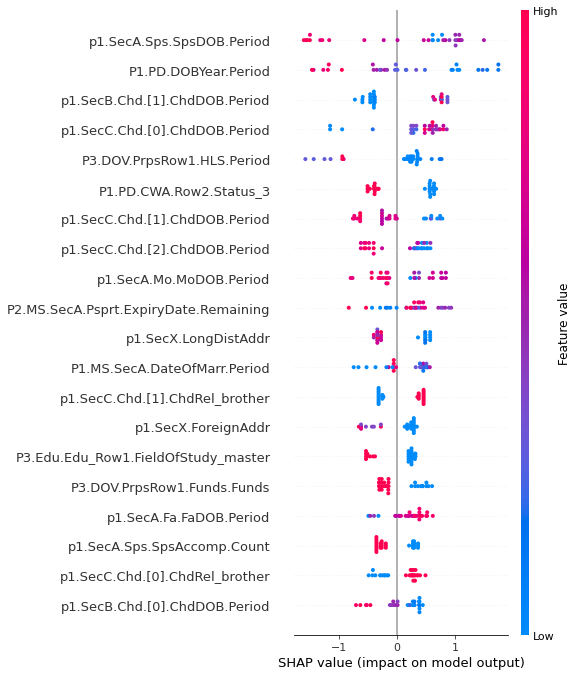

In [43]:
shap.summary_plot(shap_values, xt_eval, feature_names=feature_names)

In [57]:
shap.force_plot(explainer.expected_value, shap_values, feature_names=feature_names)

accepted


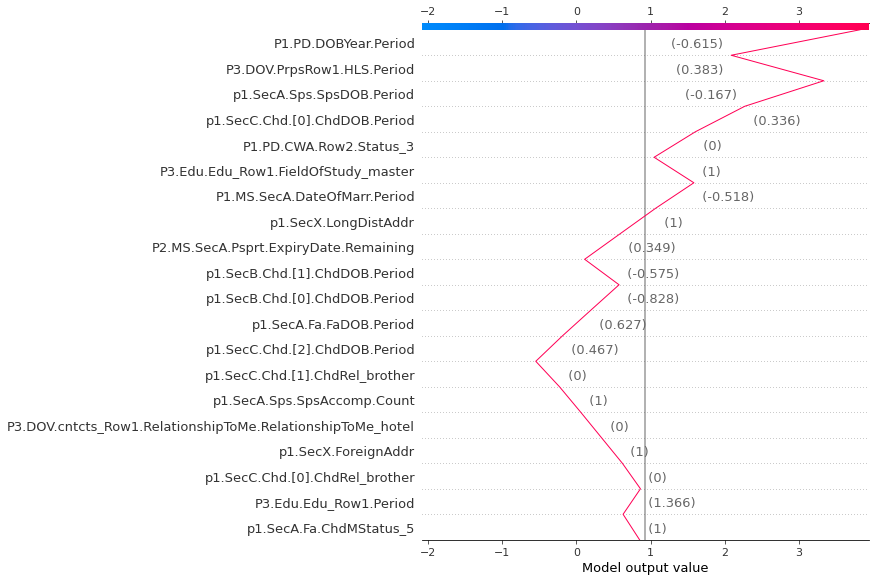

In [52]:
i = 0
print('accepted' if yt_eval[i] == [1] else 'rejected')
shap.decision_plot(explainer.expected_value, shap_values[i], xt_eval[i], feature_names=feature_names)


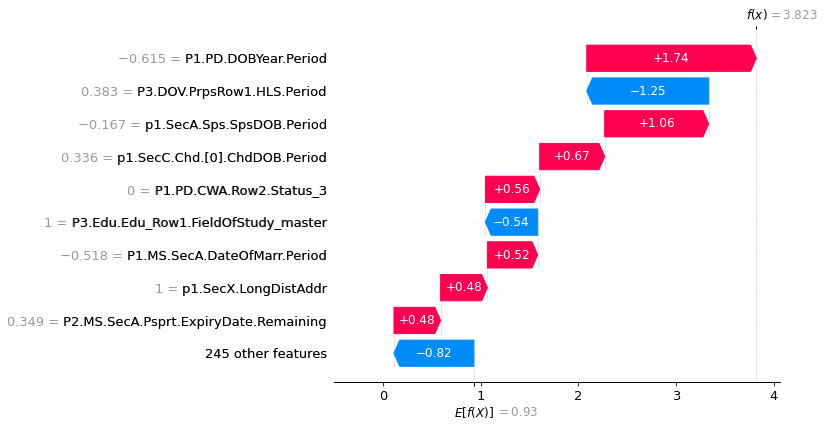

In [63]:
i = 0
shap.plots.waterfall(explainer(xt_eval)[i])

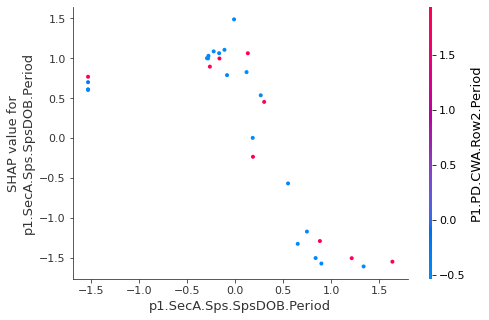

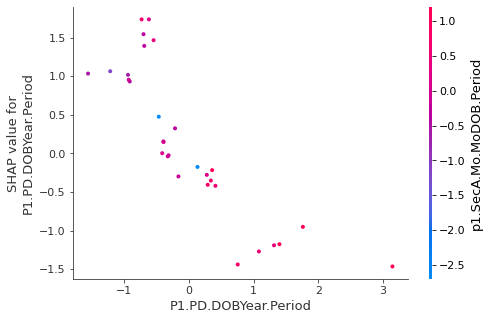

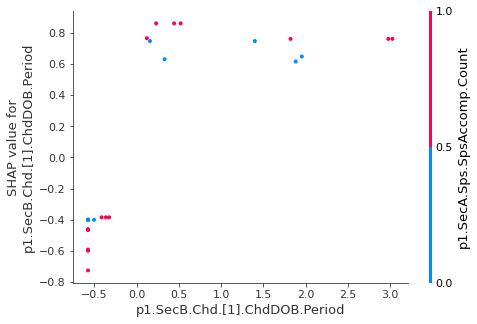

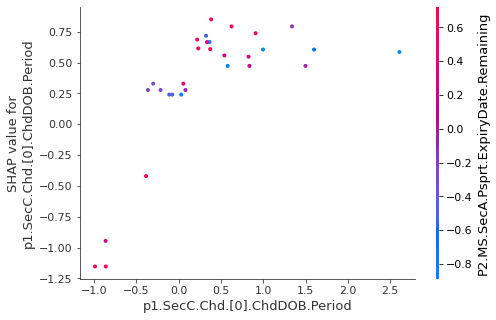

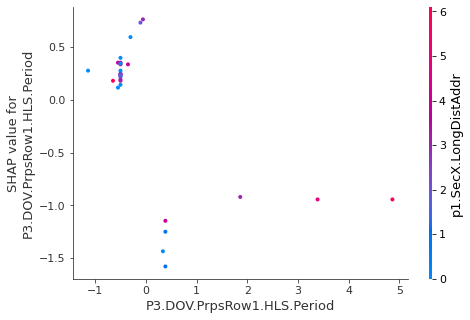

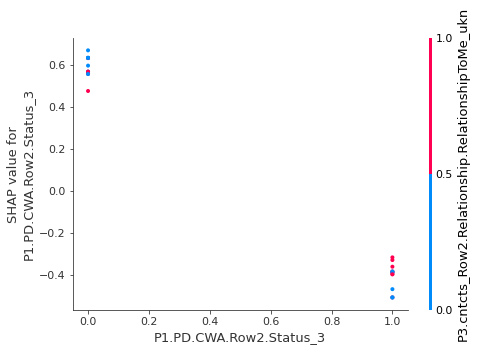

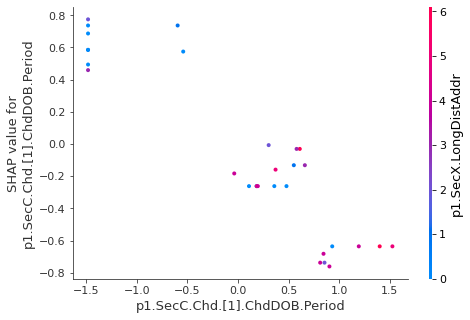

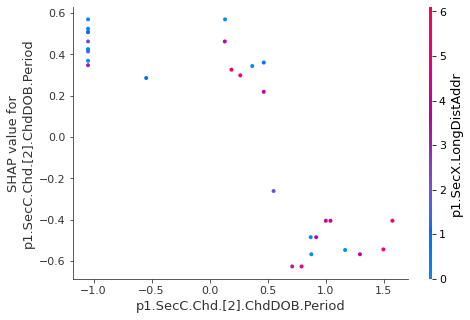

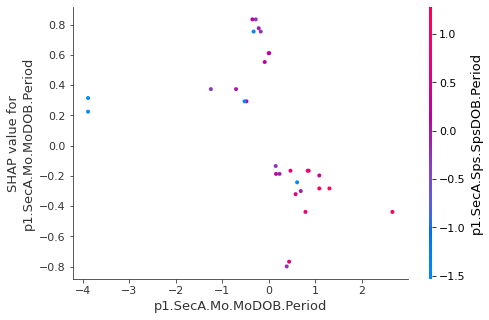

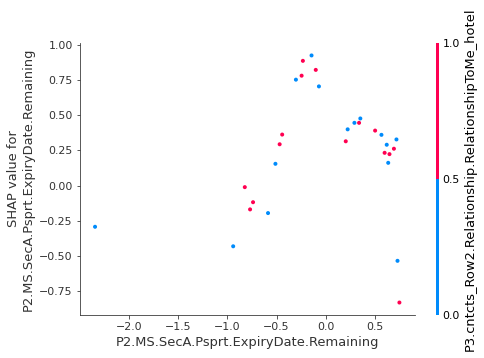

In [53]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_indices = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(10):
    shap.dependence_plot(top_indices[i], shap_values, xt_eval, feature_names=feature_names)

In [64]:
# TODO: implement this for each group (or slice in snorkel terminology)
shap.group_difference_plot

<function shap.plots._group_difference.group_difference(shap_values, group_mask, feature_names=None, xlabel=None, xmin=None, xmax=None, max_display=None, sort=True, show=True)>